# FEATURE EXTRACTION EXAMPLE FOR IMPEDANCE OF A PARTICIPANT

In [1]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw impedance data coming from VU-AMS 5fs
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in another format as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next cells
df_impedance = pd.read_hdf('df_impedance.h5', 'df_impedance')
df_impedance

RSP_Raw Task_Label_2
0        1.171893e+07          NaN
1        1.171893e+07          NaN
2        1.171893e+07          NaN
3        1.170989e+07             
4        1.170989e+07             
...               ...          ...
1034996  1.074310e+07          NaN
1034997  1.074310e+07          NaN
1034998  1.074310e+07          NaN
1034999  1.073407e+07          NaN
1035000  1.073407e+07          NaN

[1035001 rows x 2 columns]

In [2]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.55,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_impedance(
    rsp_signal,
    sampling_rate=250,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [3]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
import matplotlib.pyplot as plt
import neurokit2 as nk
def process_and_visualize_impedance(shiftedimp_data, participant_id, tasks):
    # segmenting the larger dataframe into task-specific dataframes
    tasks_dataframes_impedance = {}
    for task in tasks:
        task_indices = shiftedimp_data[shiftedimp_data['Task_Label_2'] == task].index
        if not task_indices.empty:
            start_index = task_indices[0] - 1750
            end_index = task_indices[-1] + 1750
            start_index = max(start_index, 0)
            end_index = min(end_index, len(shiftedimp_data) - 1)
            task_dataframe = shiftedimp_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes_impedance[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes_impedance = {}
    for task, task_df in tasks_dataframes_impedance.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_impedance(rsp_signal, sampling_rate=250)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes_impedance[task] = processed_data_with_label

        # visualizing segments of interest
        task_specific_indices = processed_data_with_label.index[processed_data_with_label['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]
            plt.figure(figsize=(15, 4))
            plt.plot(processed_data_with_label.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
            troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index
            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)
            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    # returning the processed dataframes
    return processed_tasks_dataframes_impedance



C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


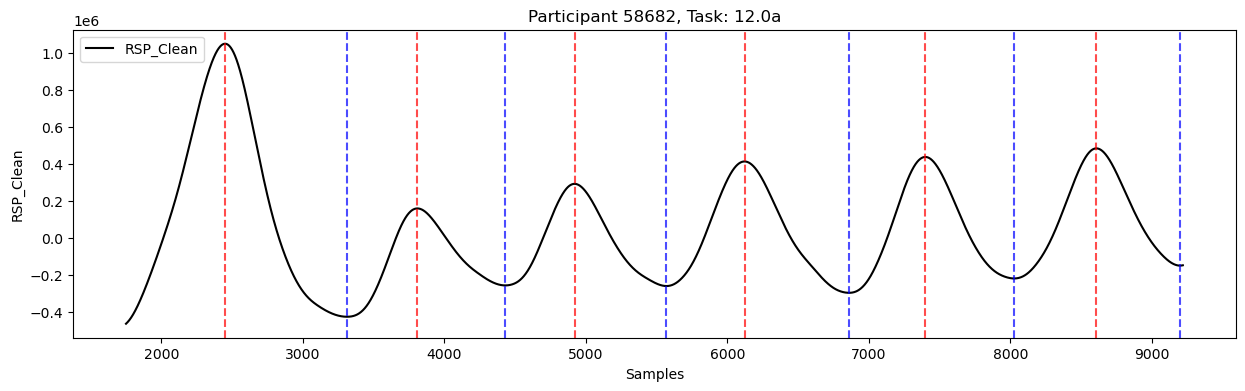

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


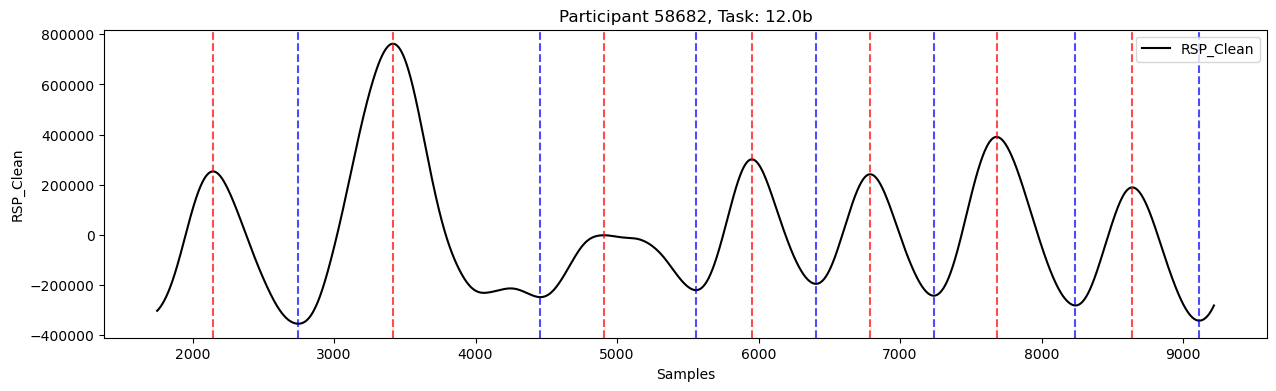

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


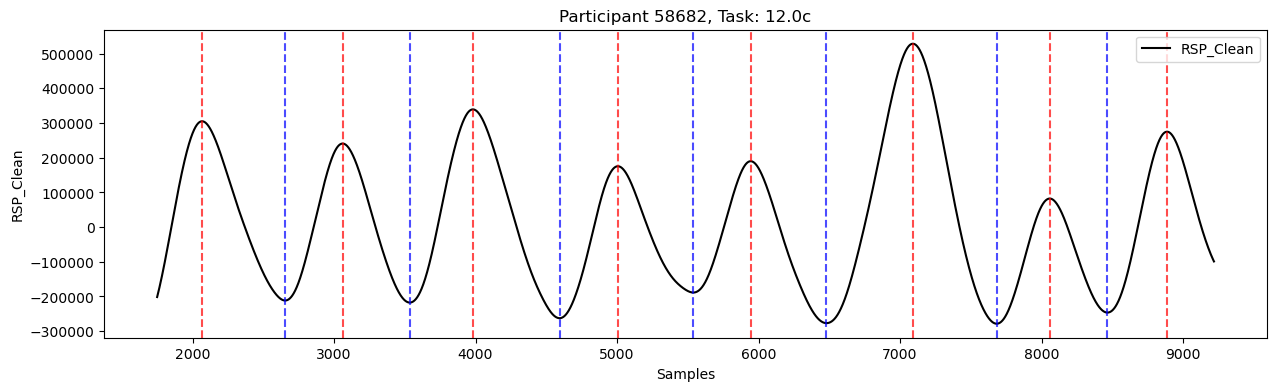

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


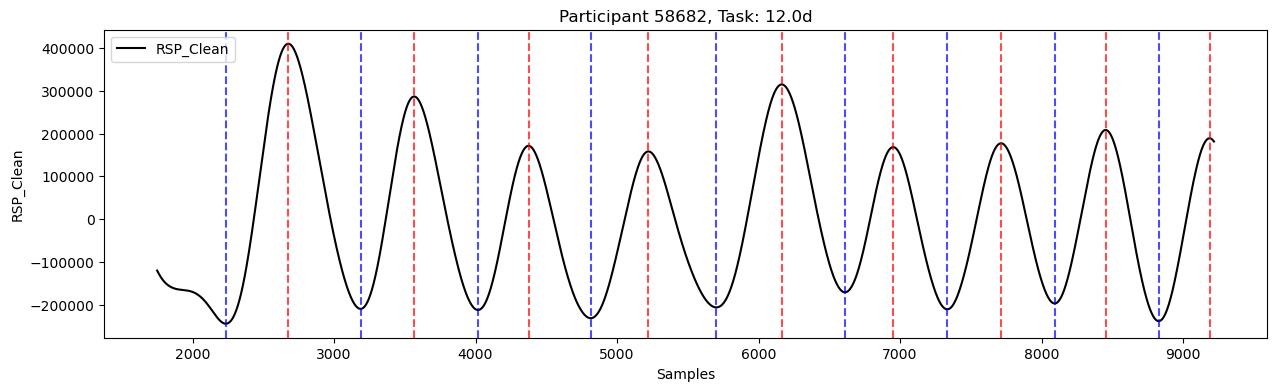

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


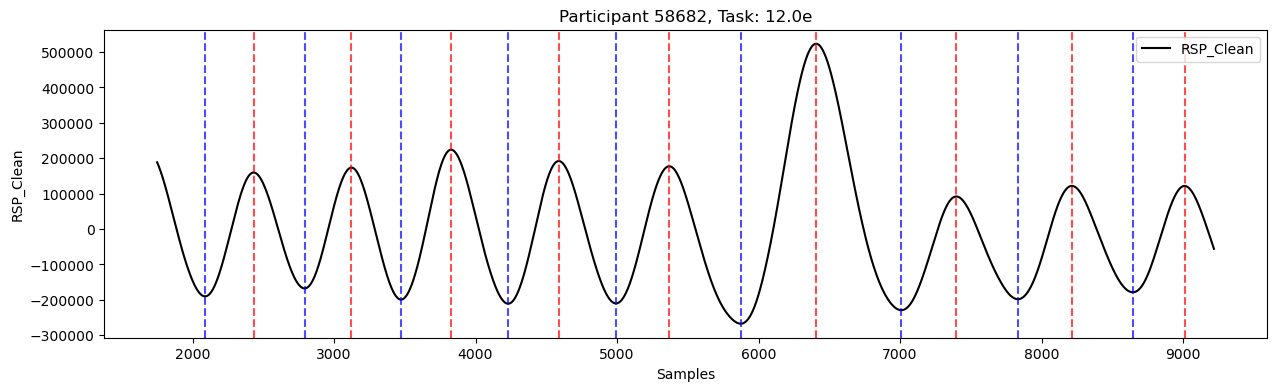

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


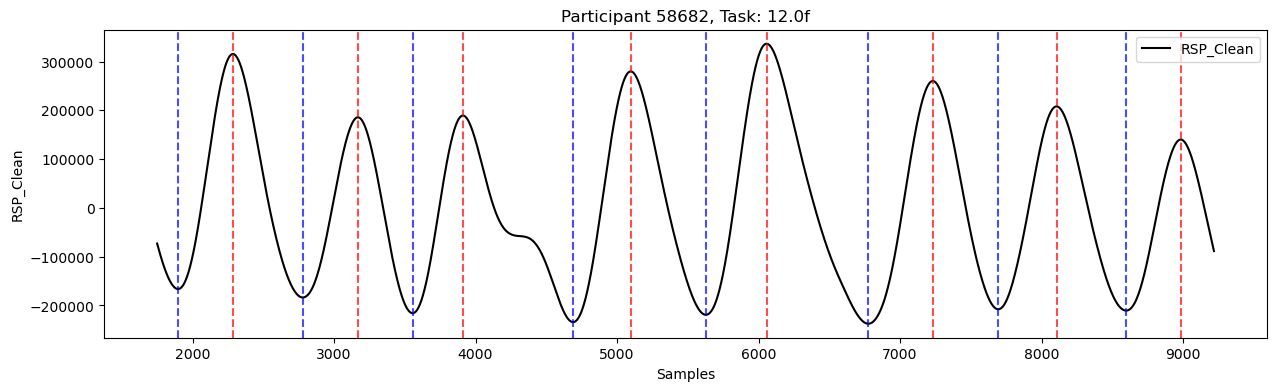

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


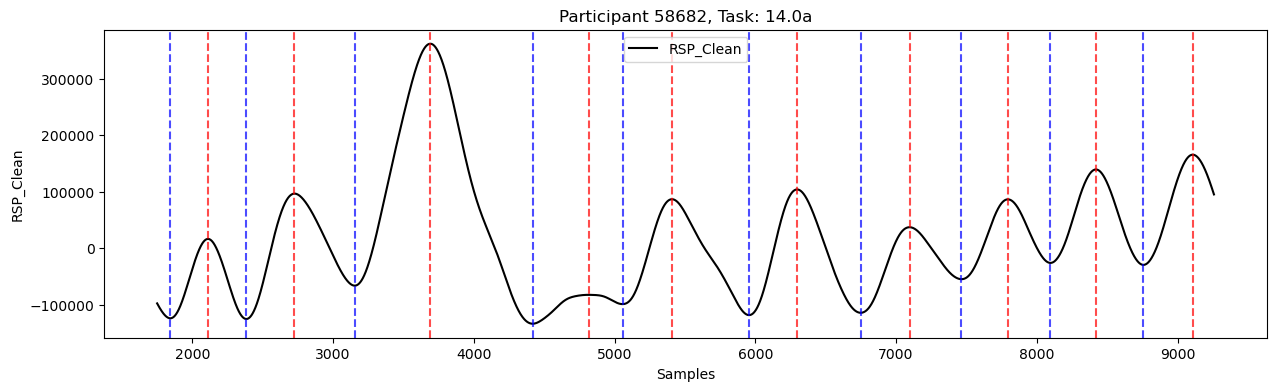

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


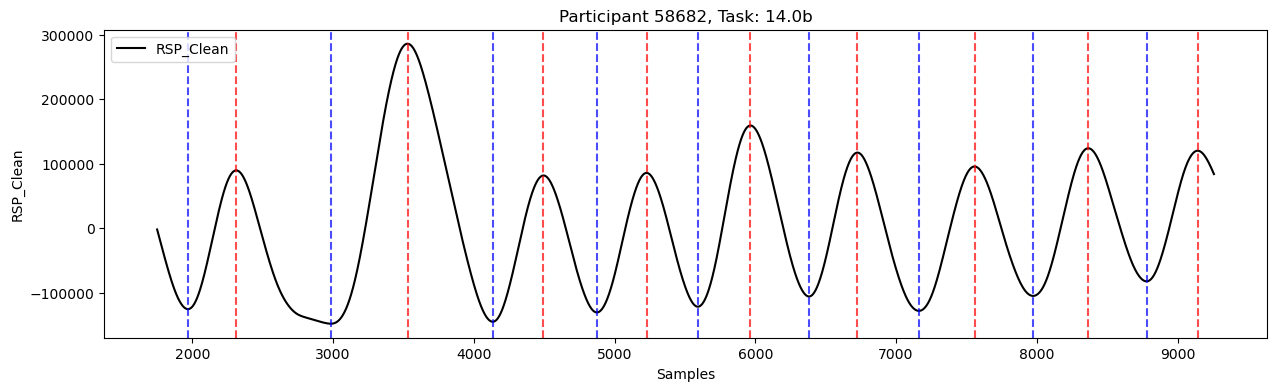

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


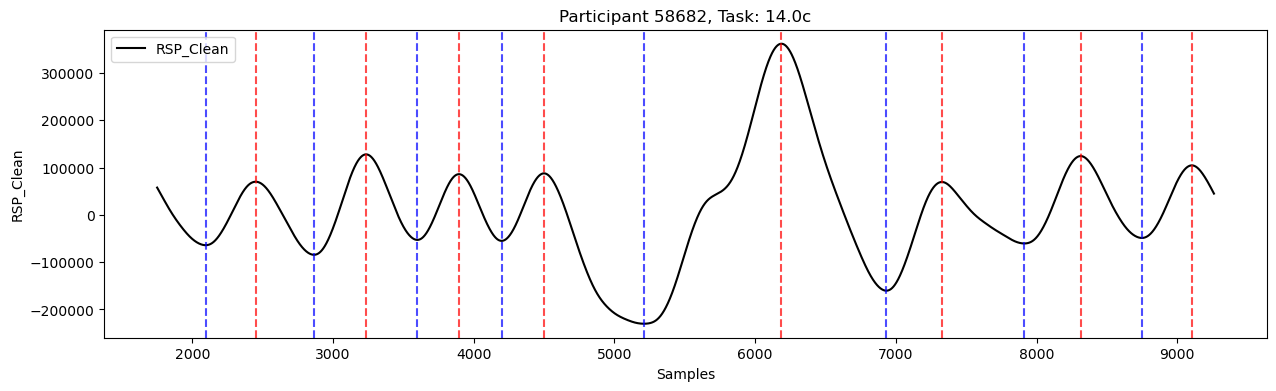

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


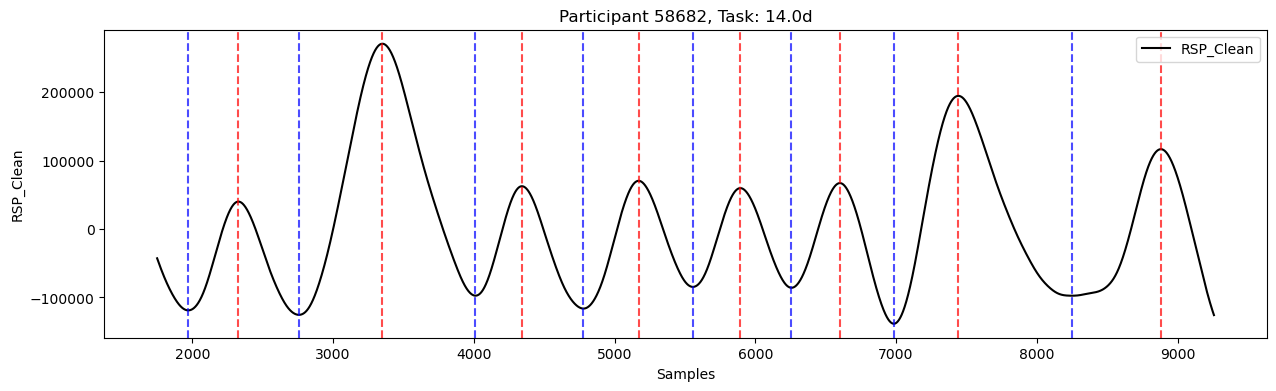

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


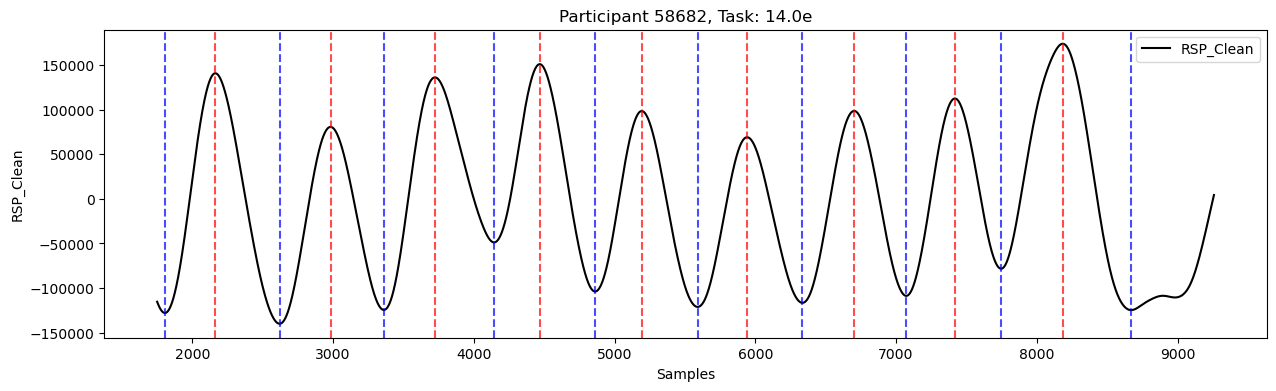

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


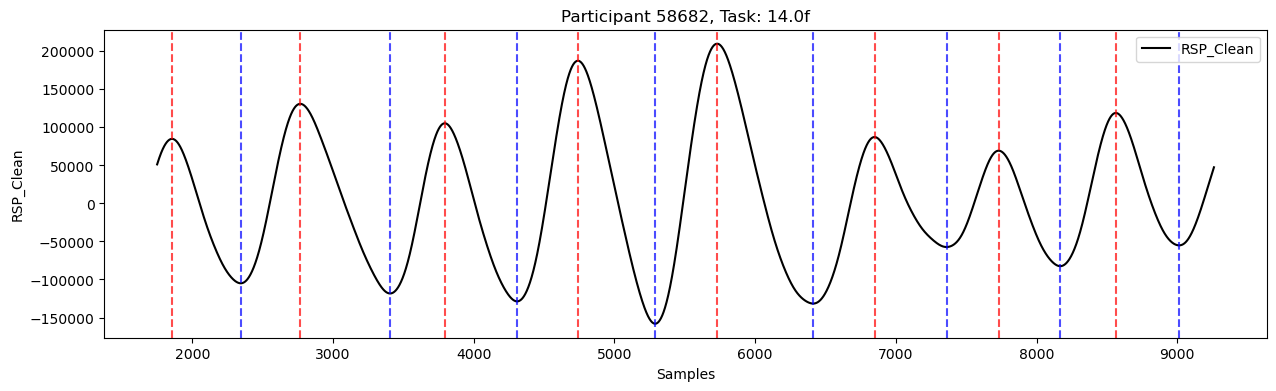

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


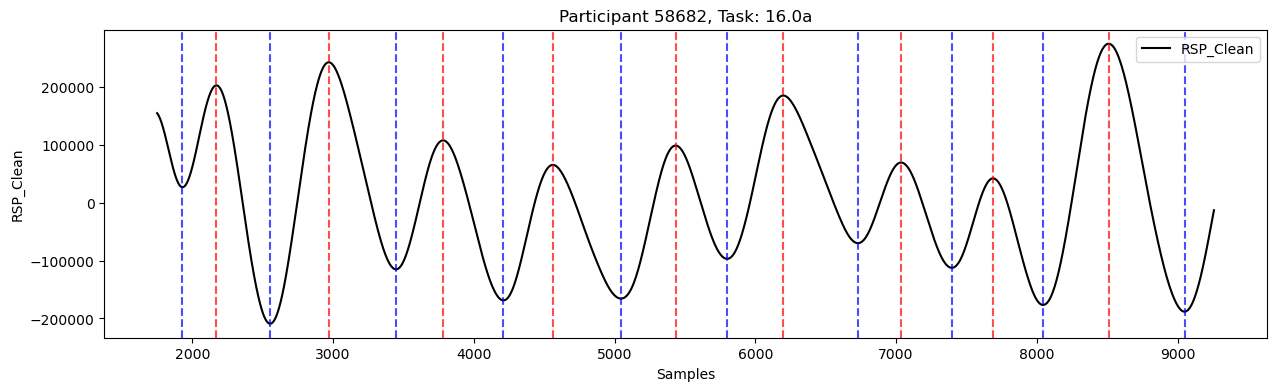

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


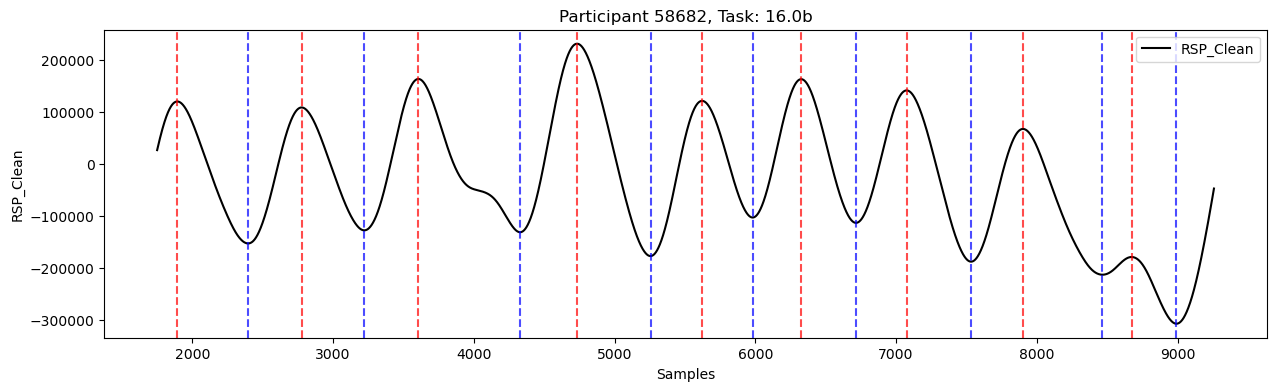

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


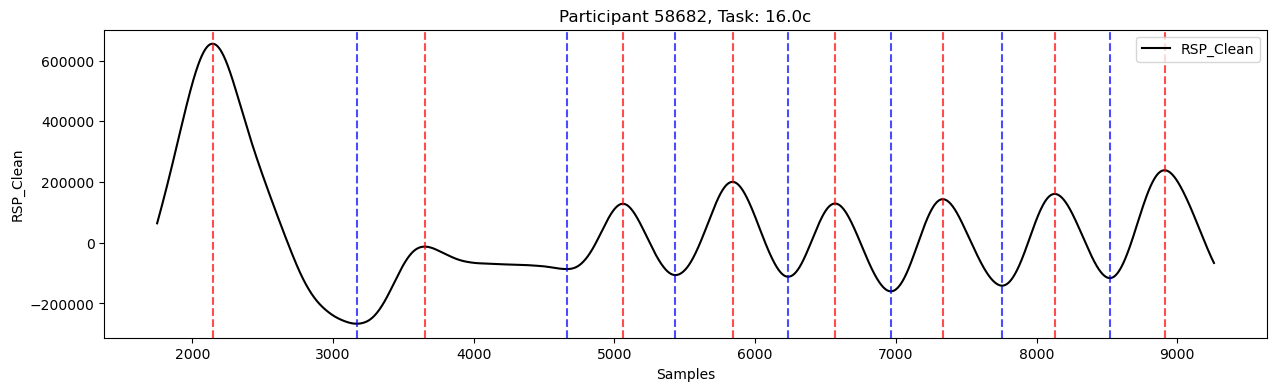

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


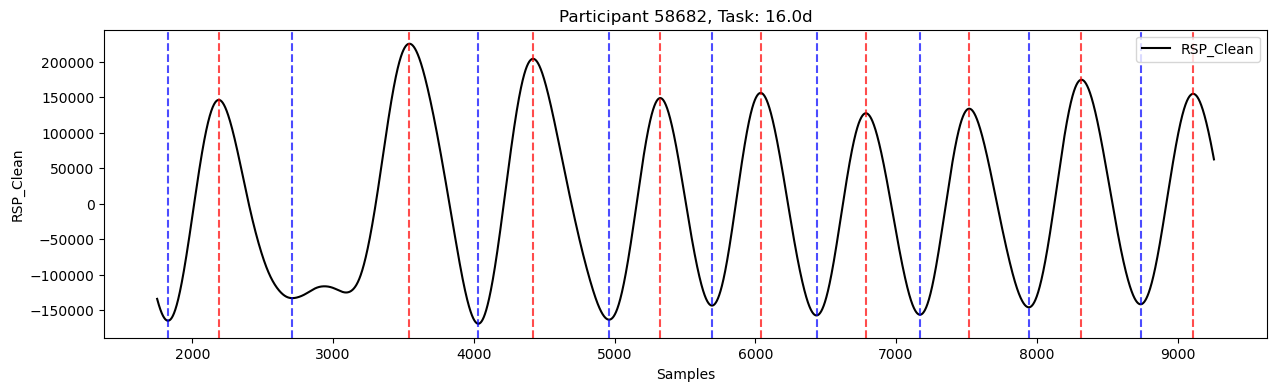

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


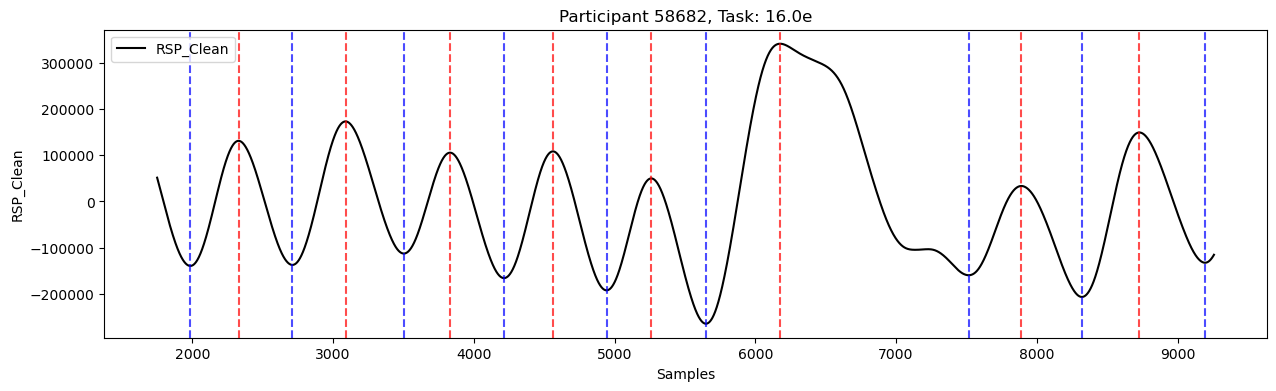

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


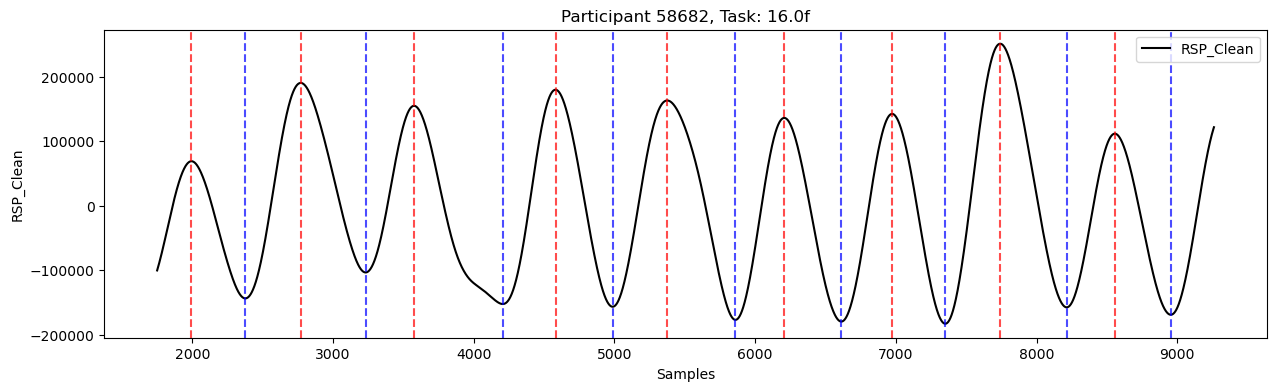

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


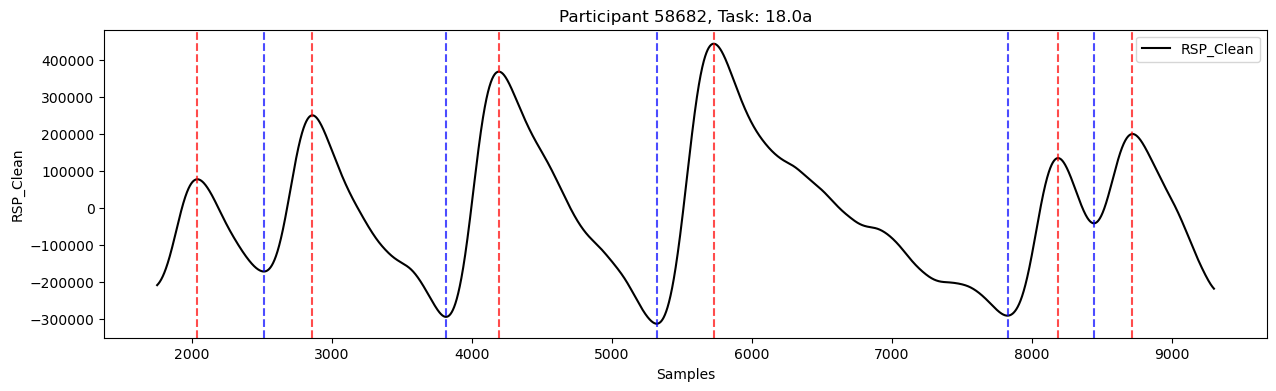

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


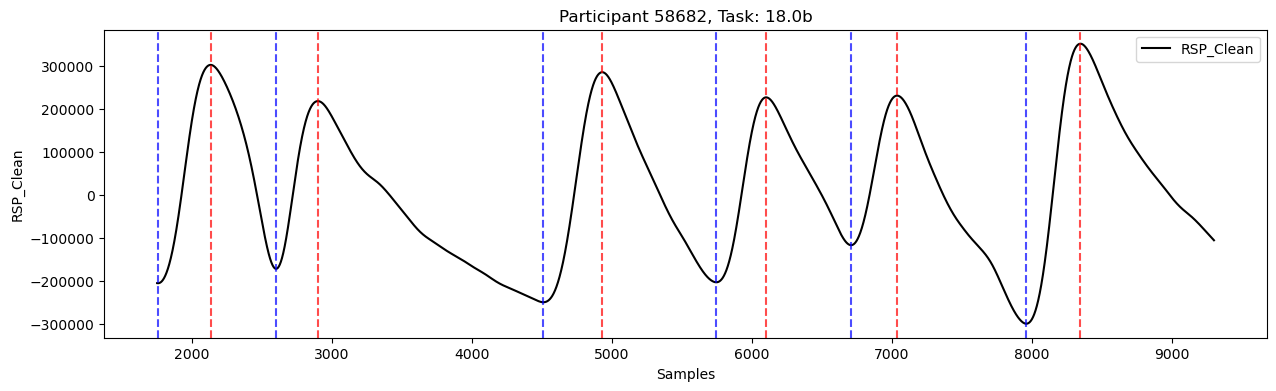

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


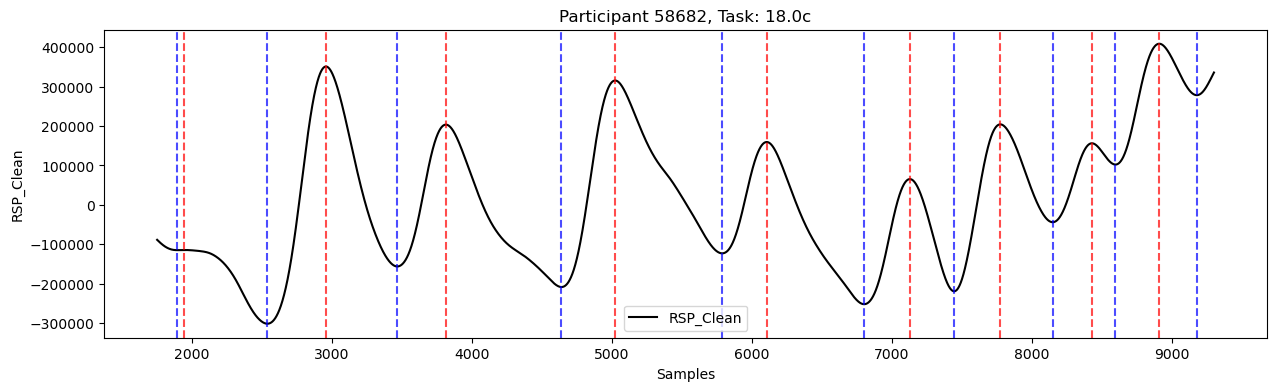

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


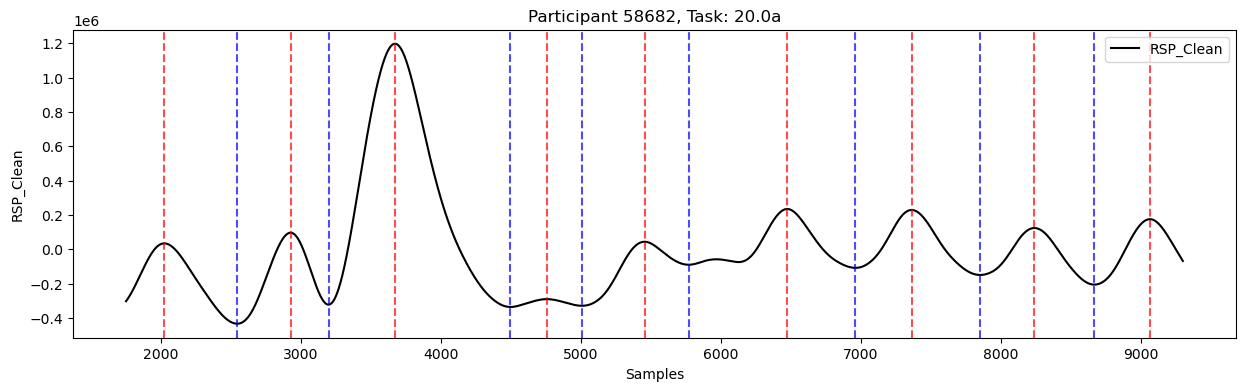

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


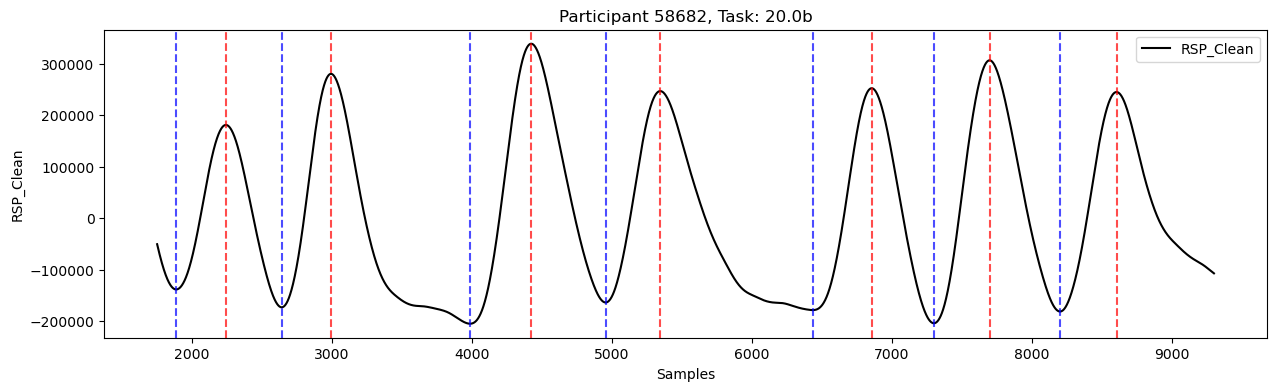

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


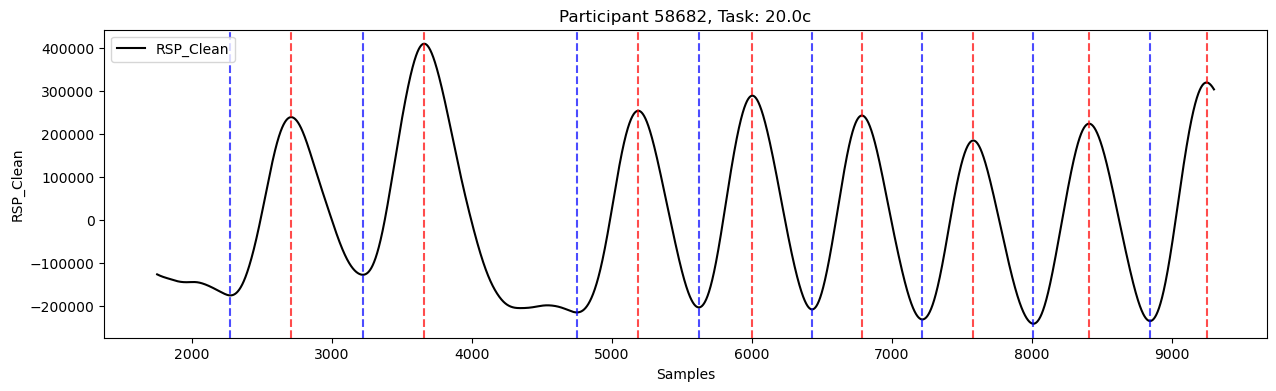

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


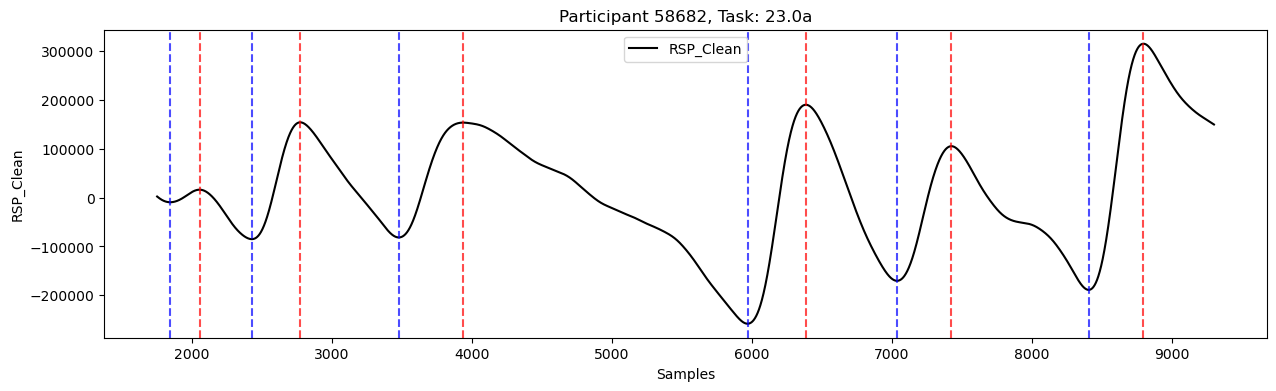

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


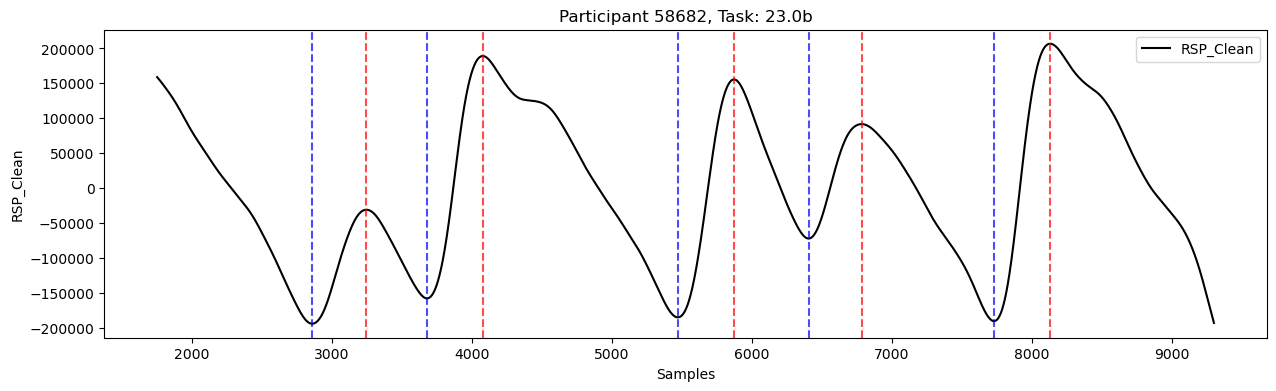

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


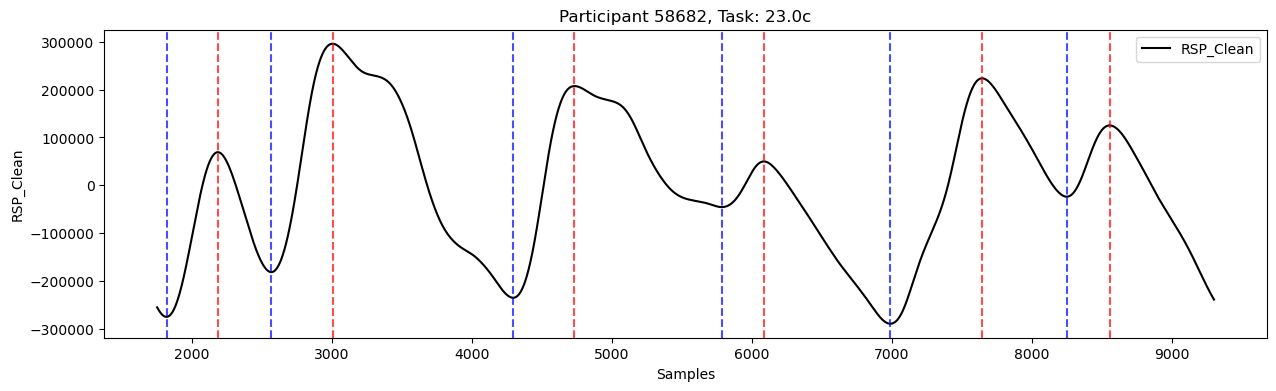

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


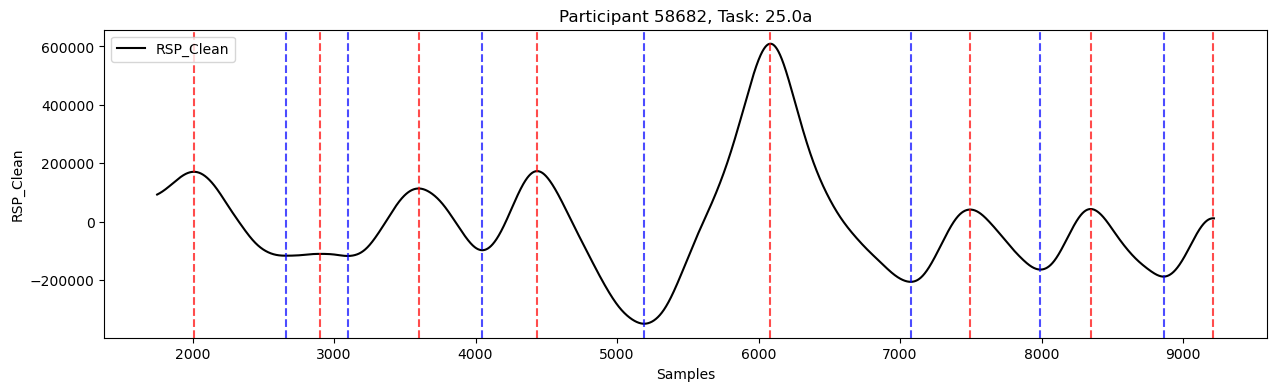

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


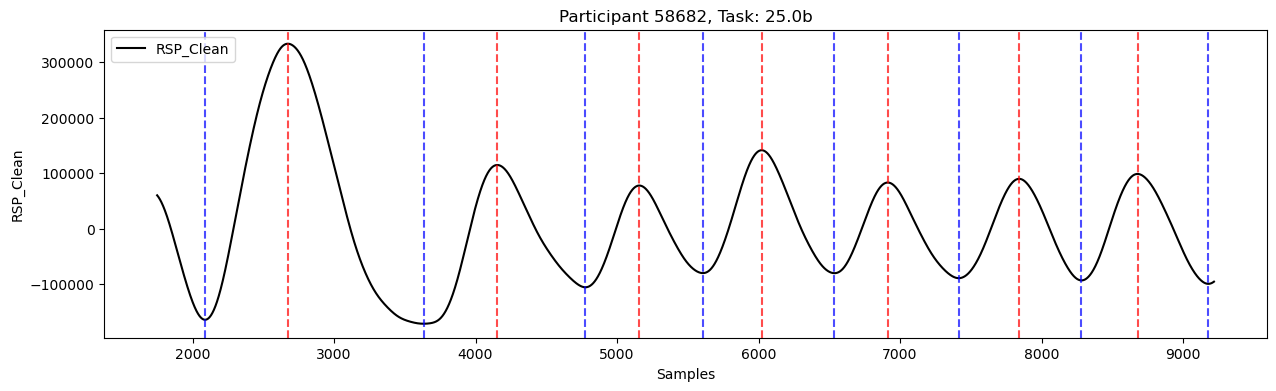

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


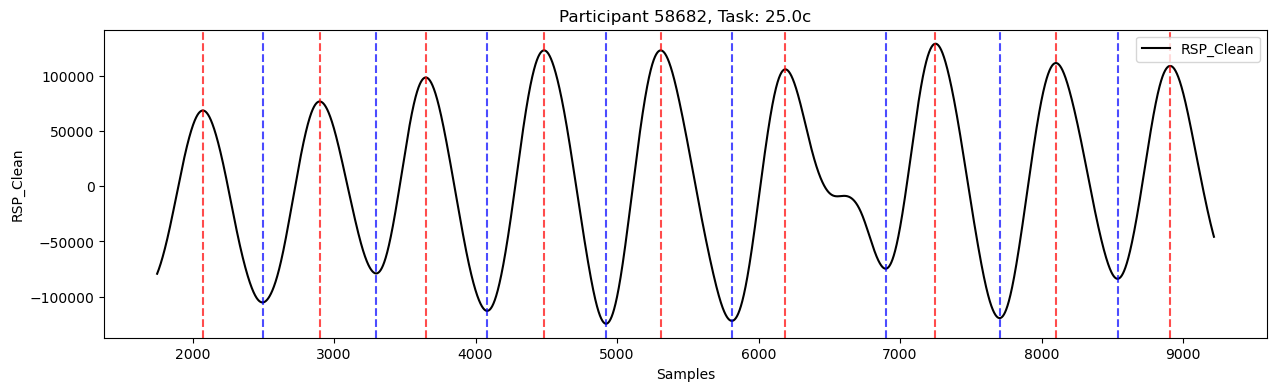

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


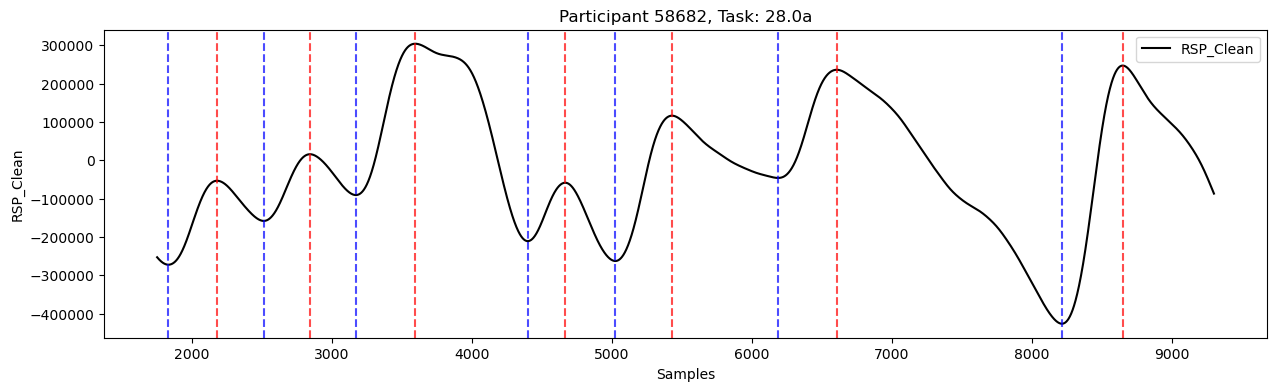

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


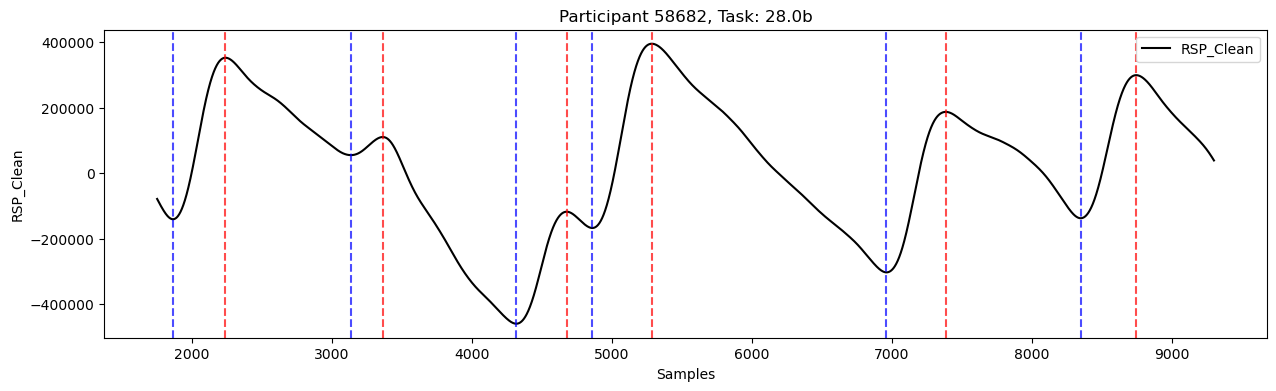

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


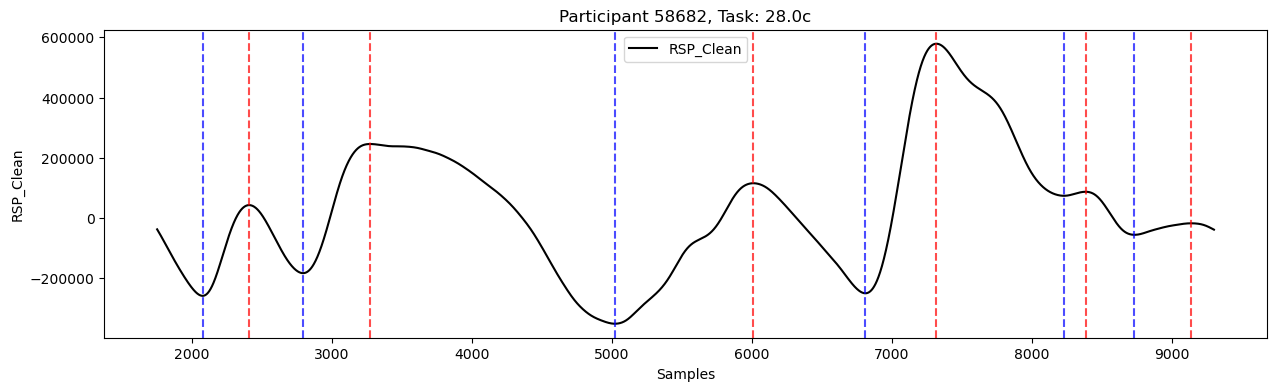

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


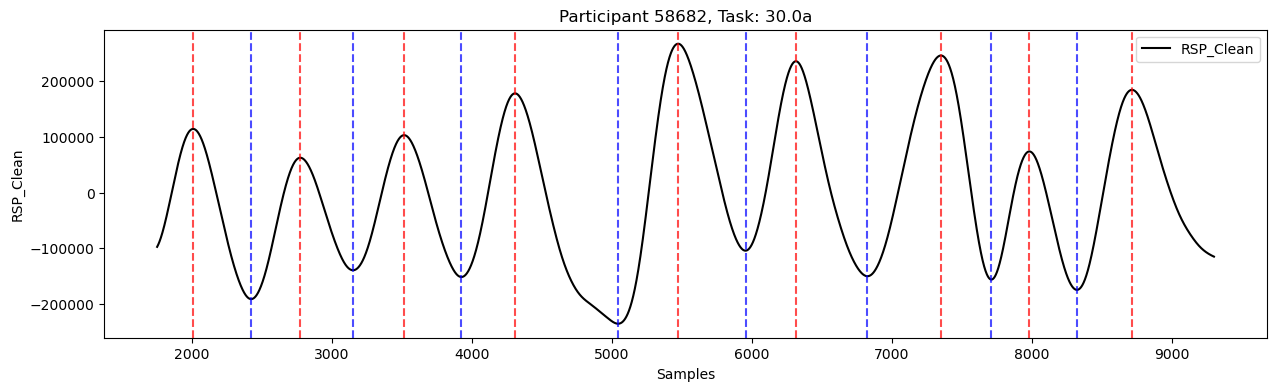

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


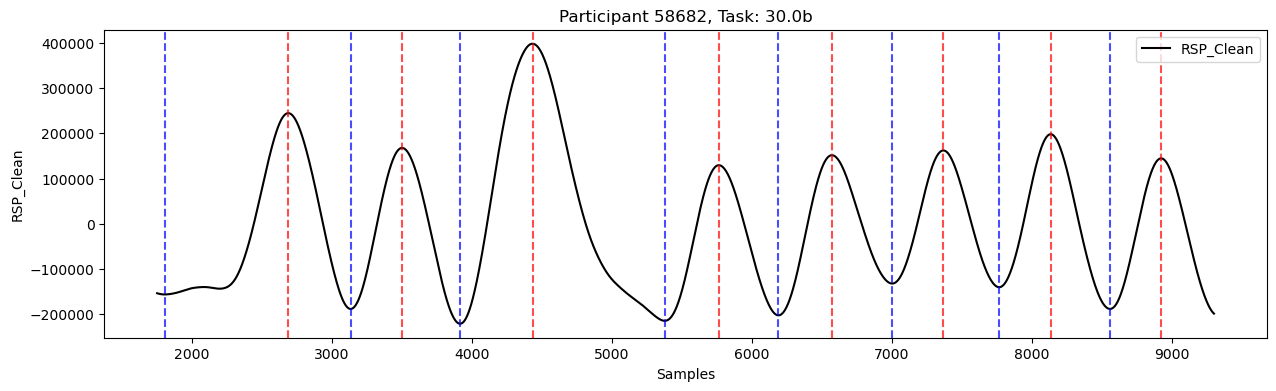

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


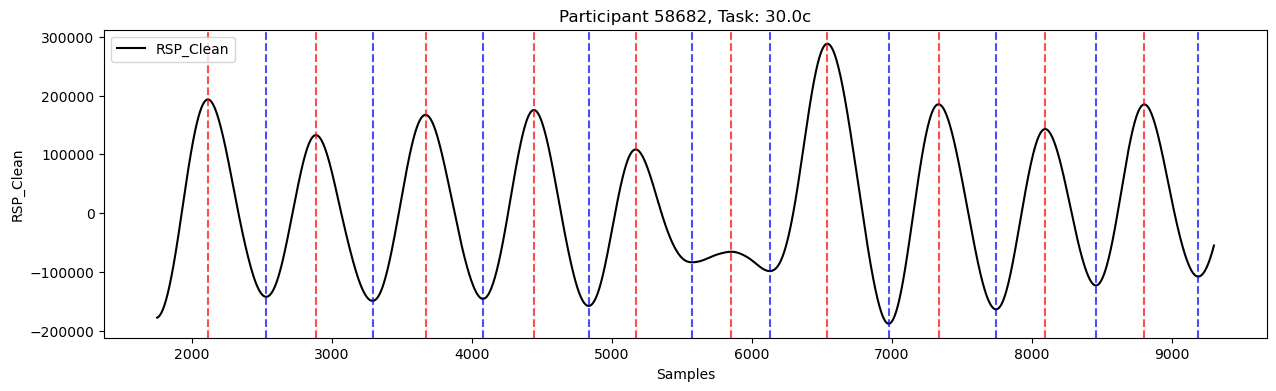

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


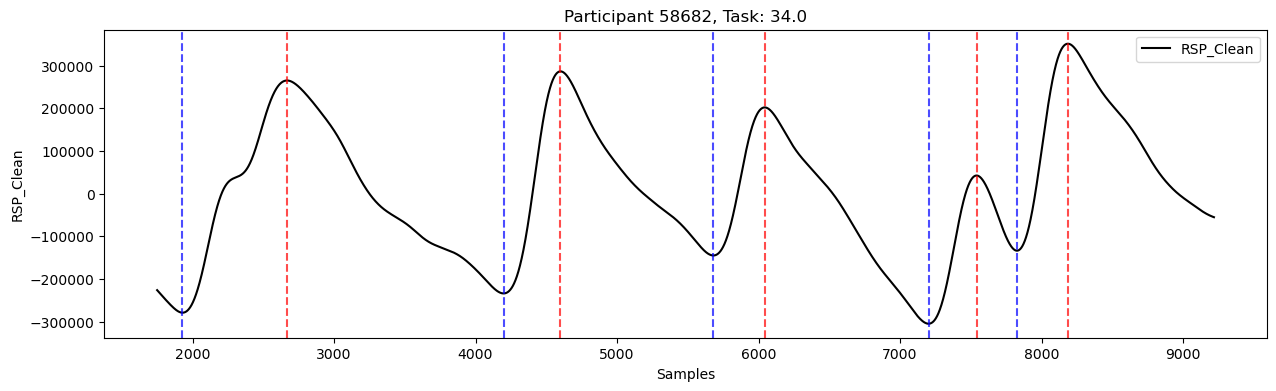

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


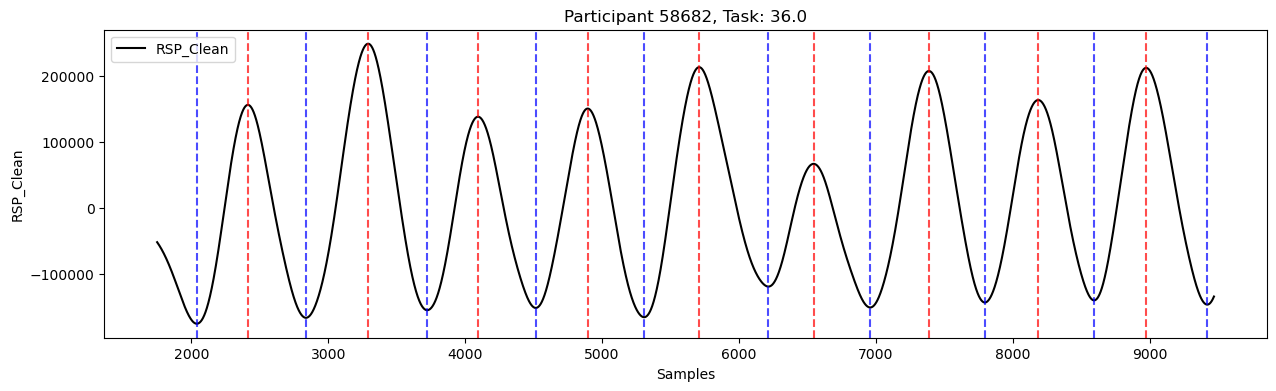

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


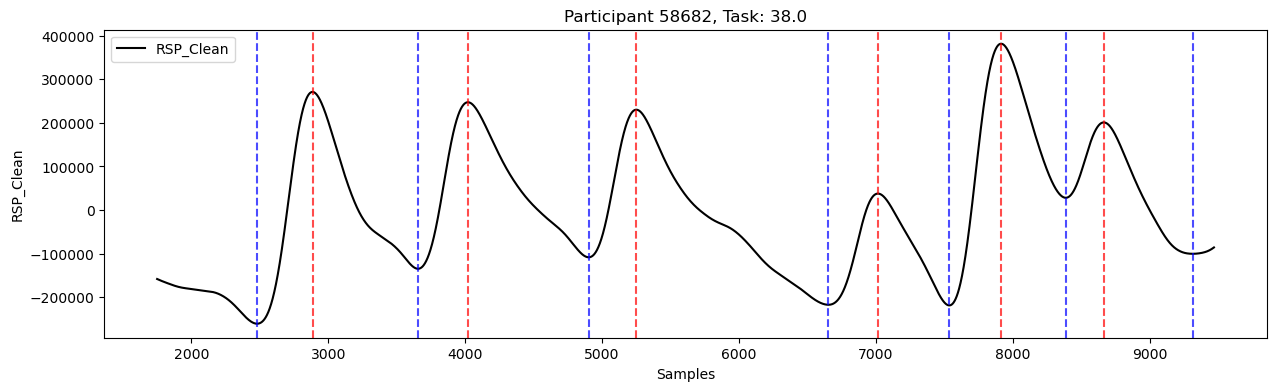

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


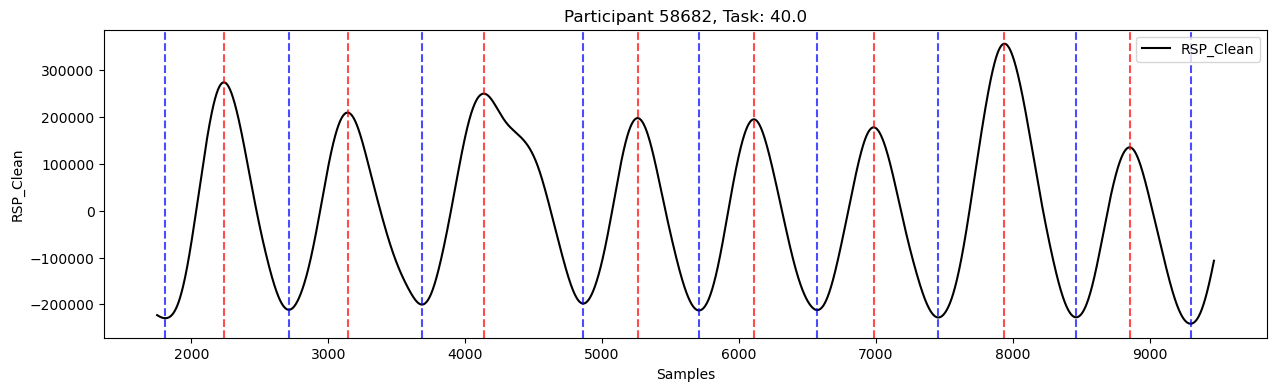

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


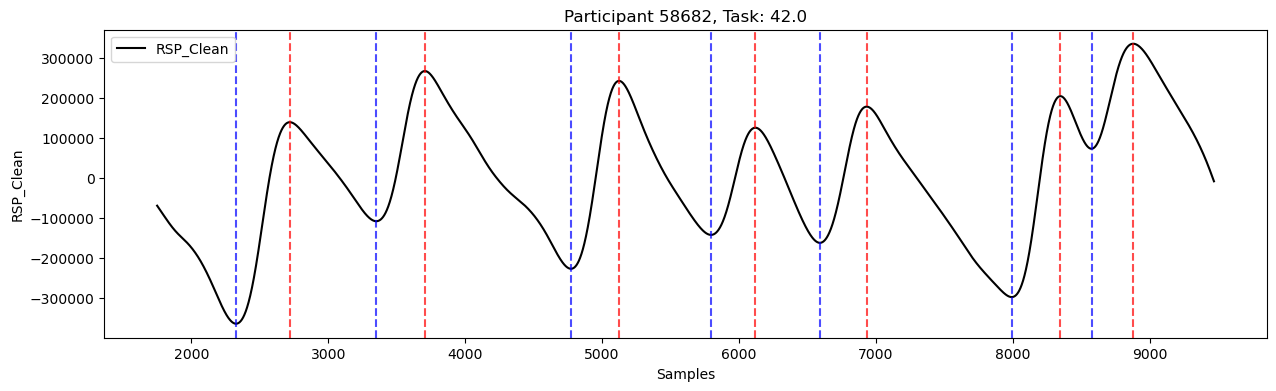

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


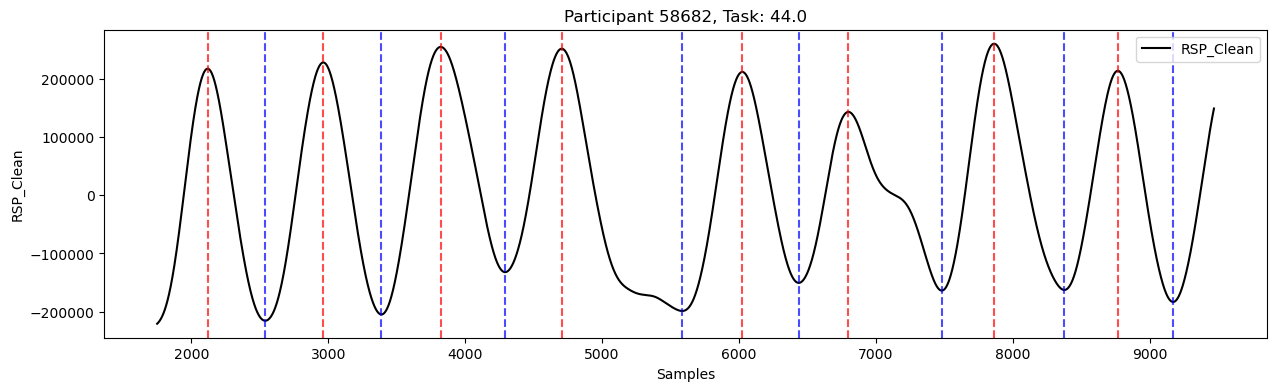

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


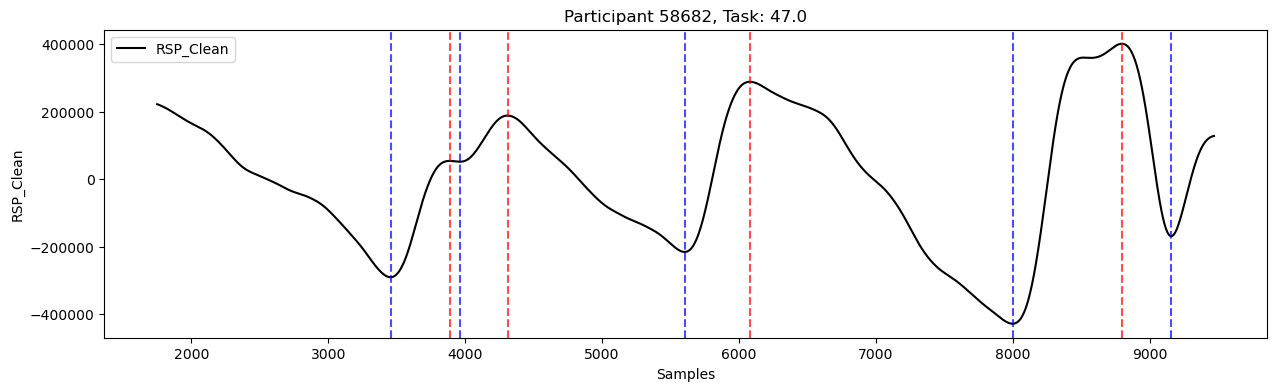

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


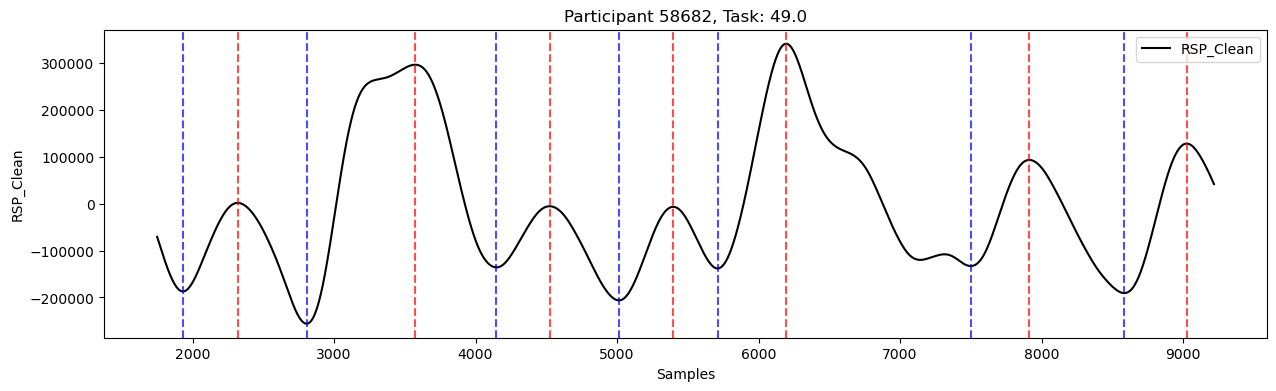

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


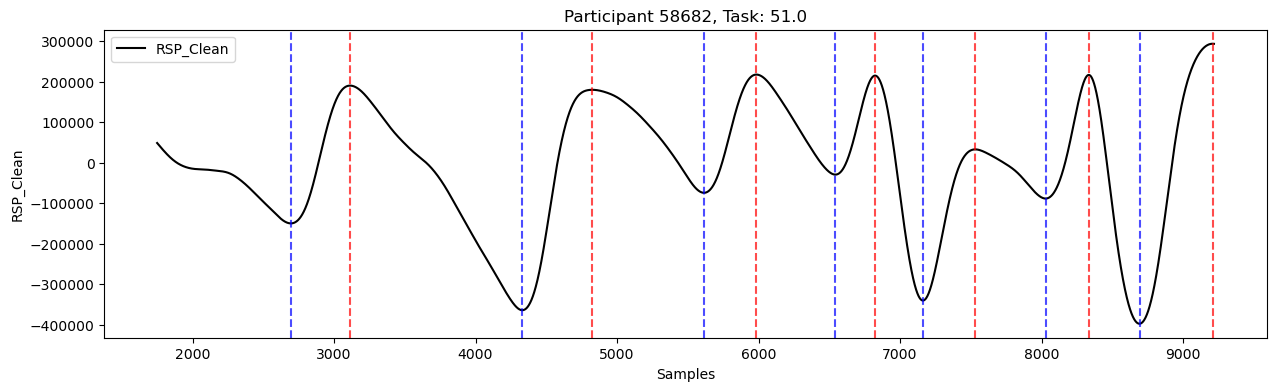

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


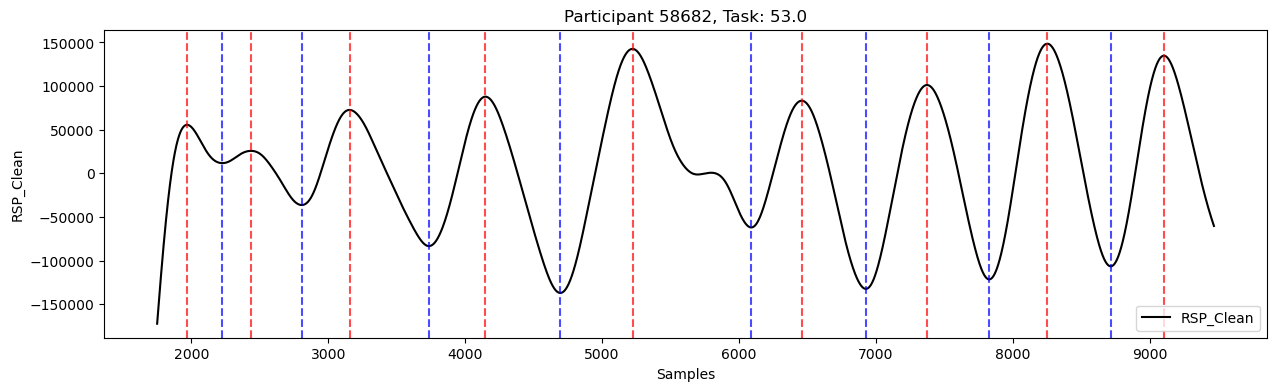

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


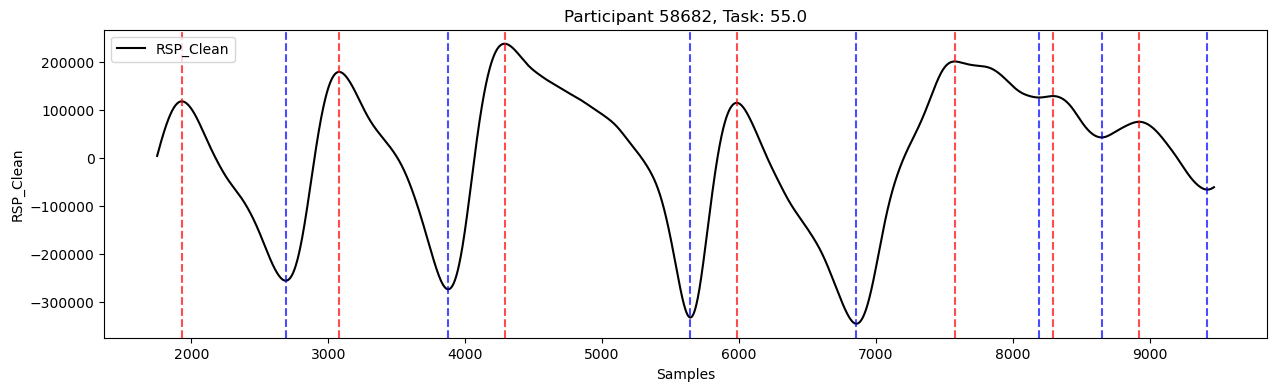

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


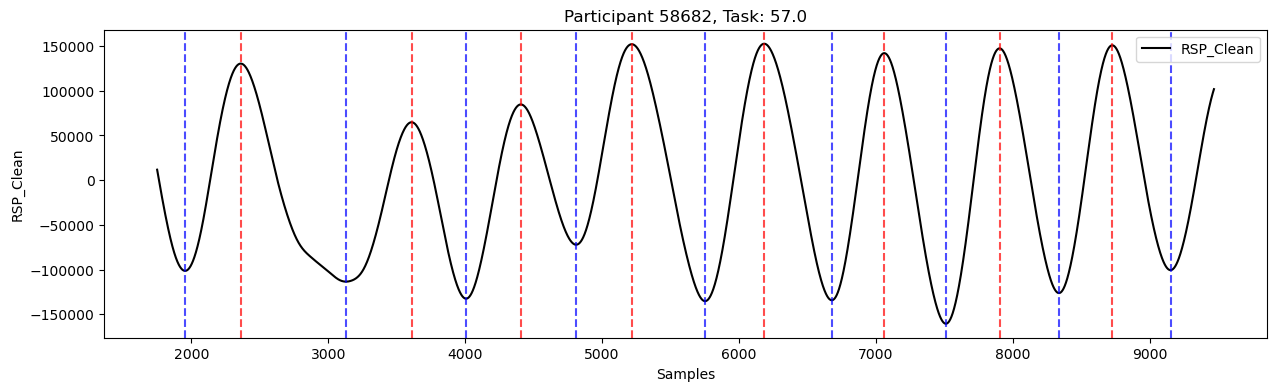

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


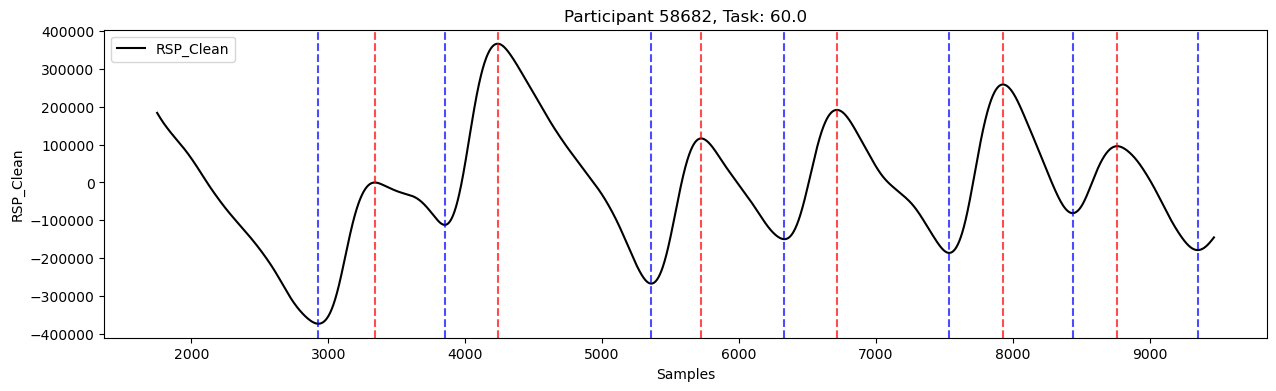

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


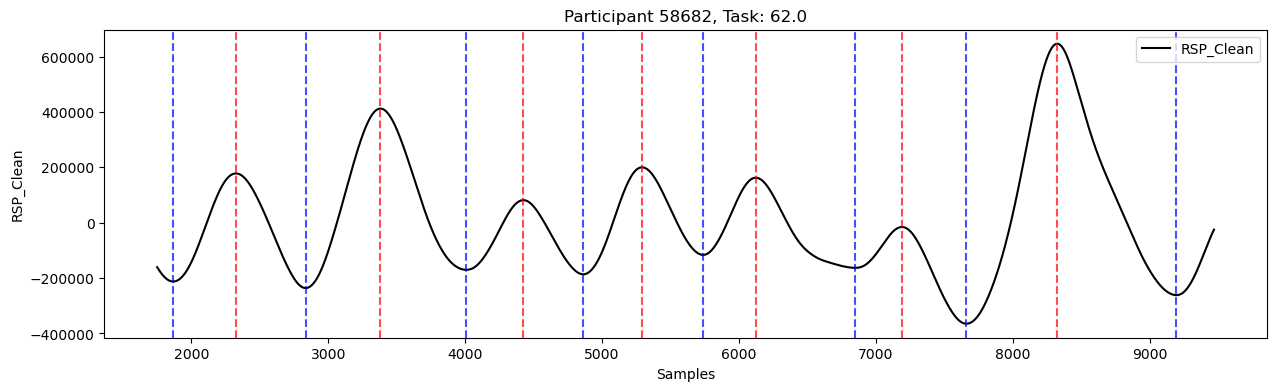

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


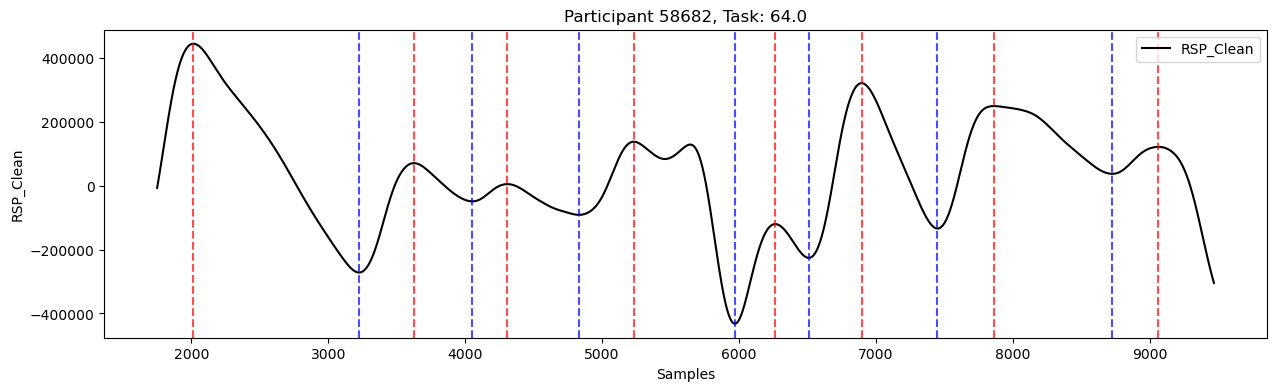

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


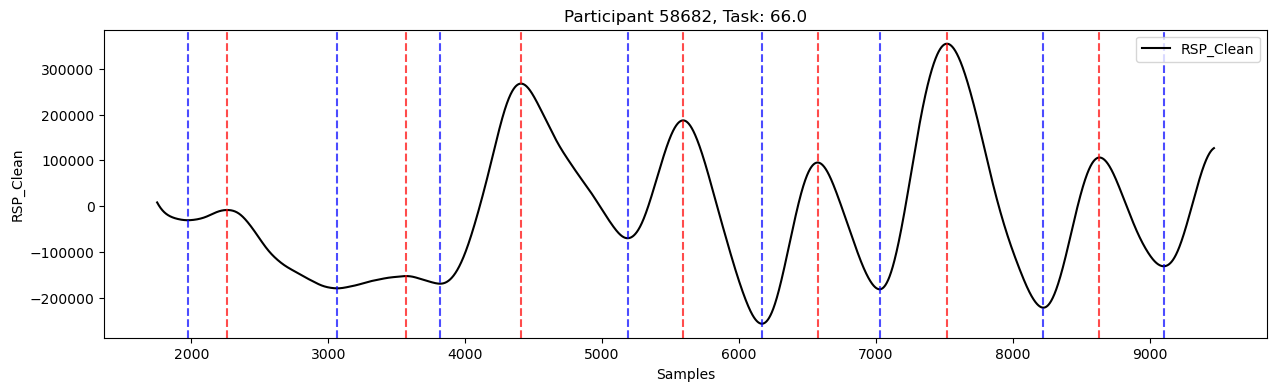

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


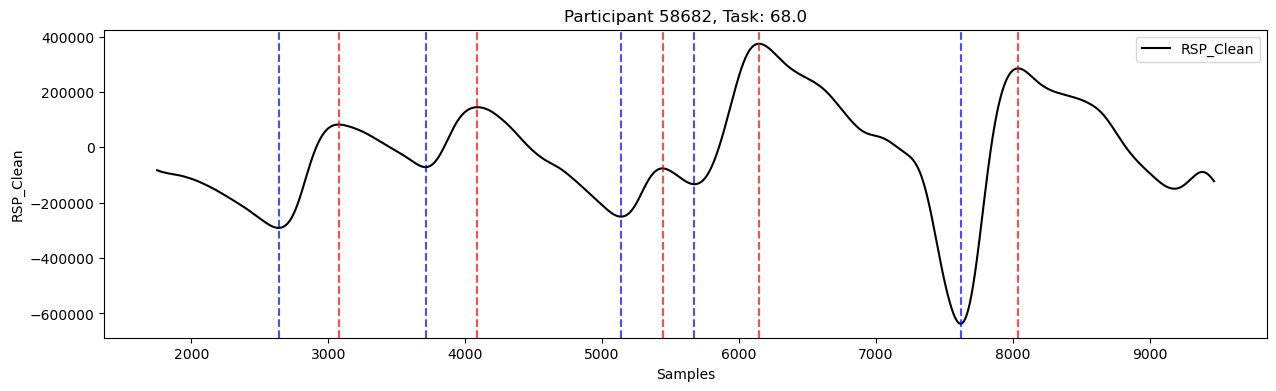

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


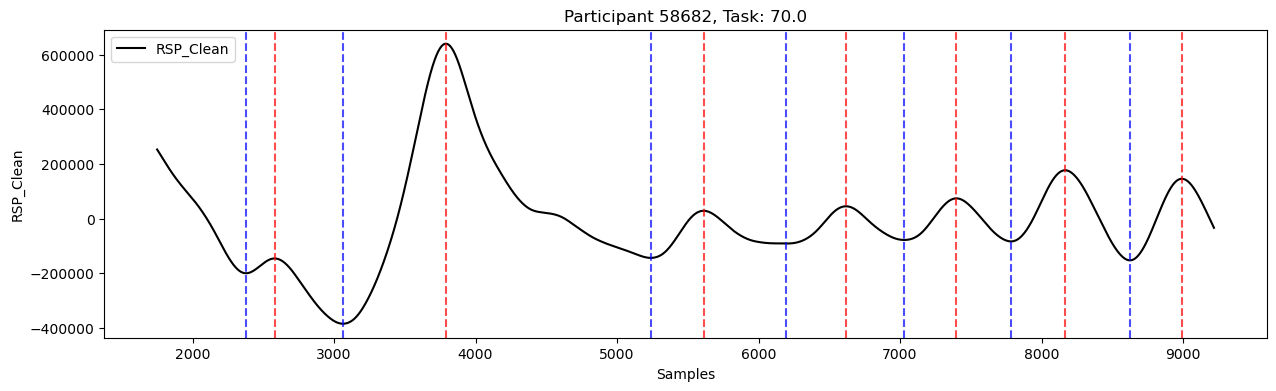

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


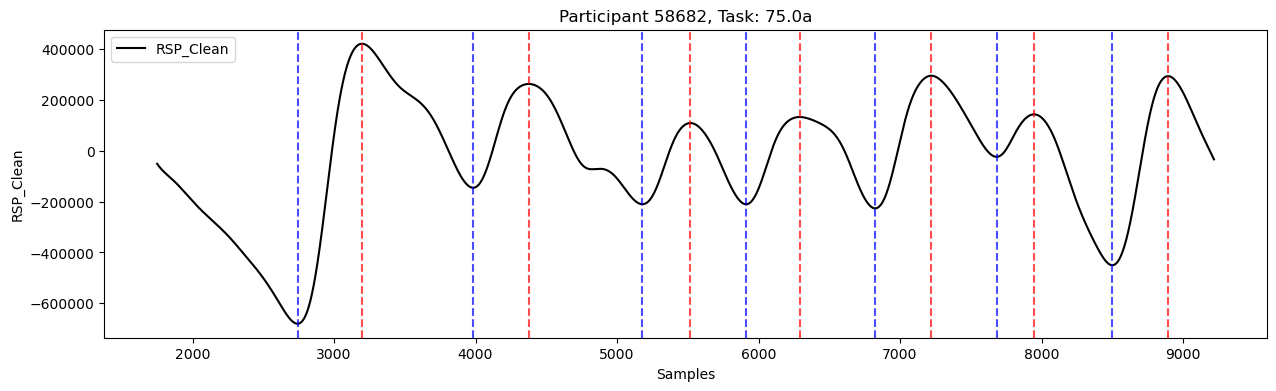

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


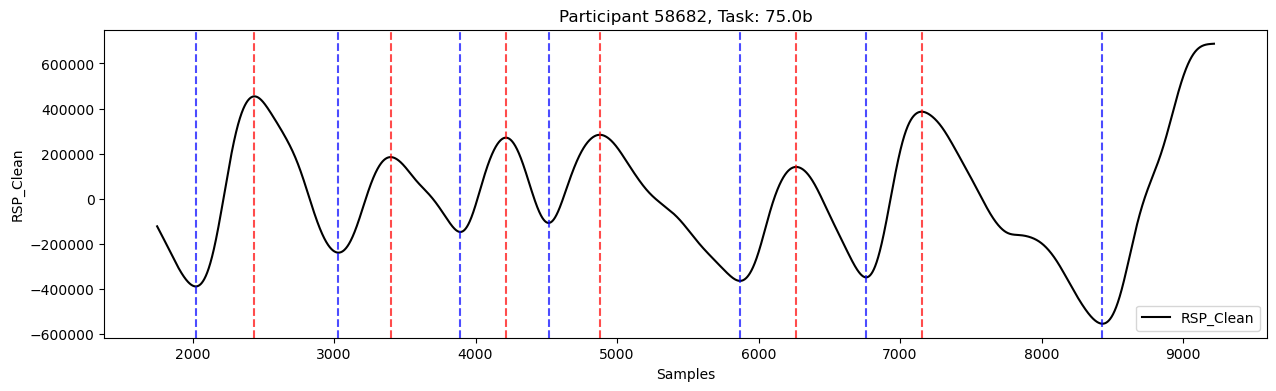

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


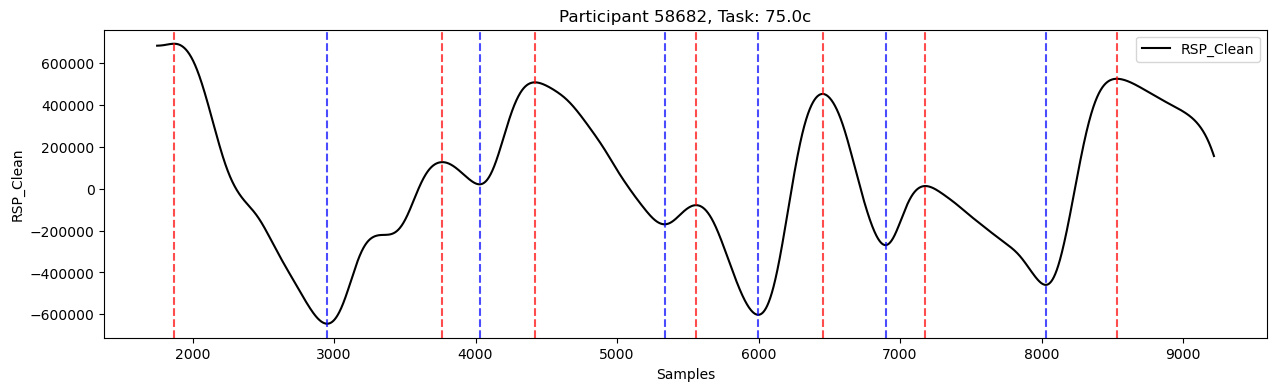

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


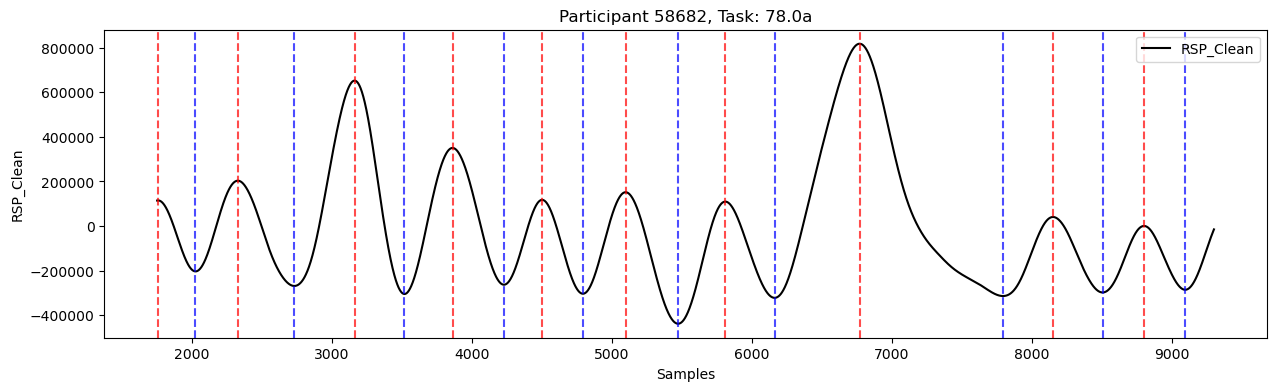

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


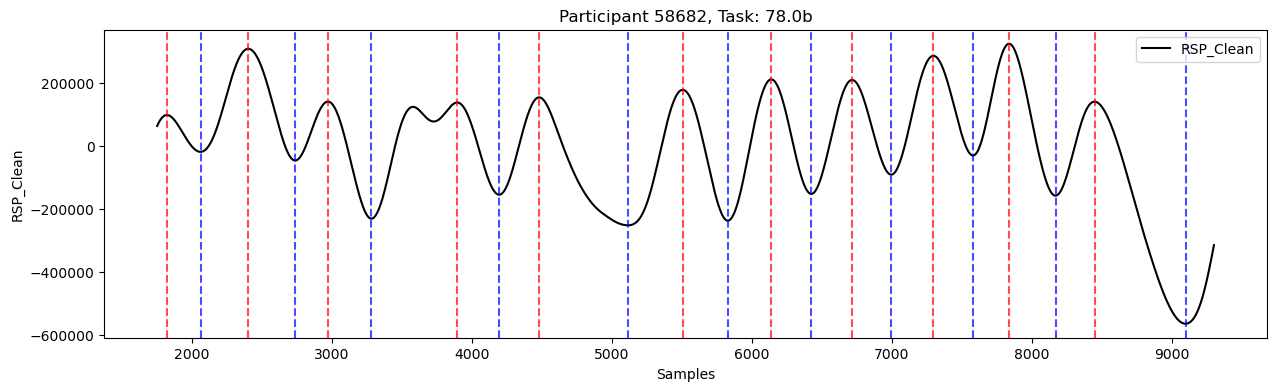

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


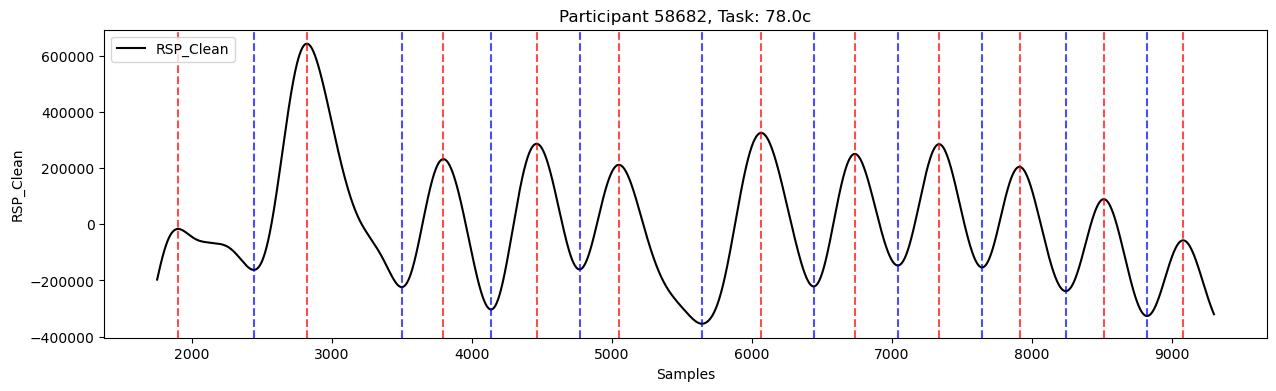

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


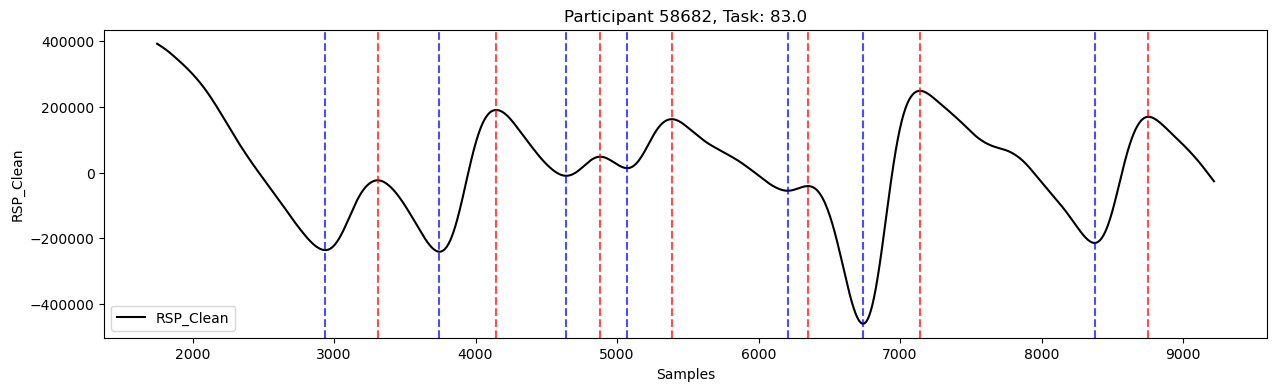

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


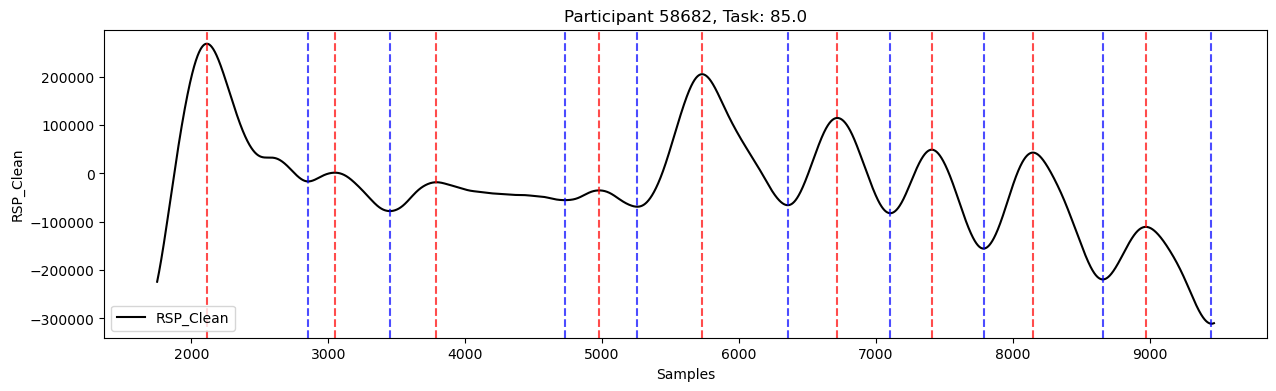

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


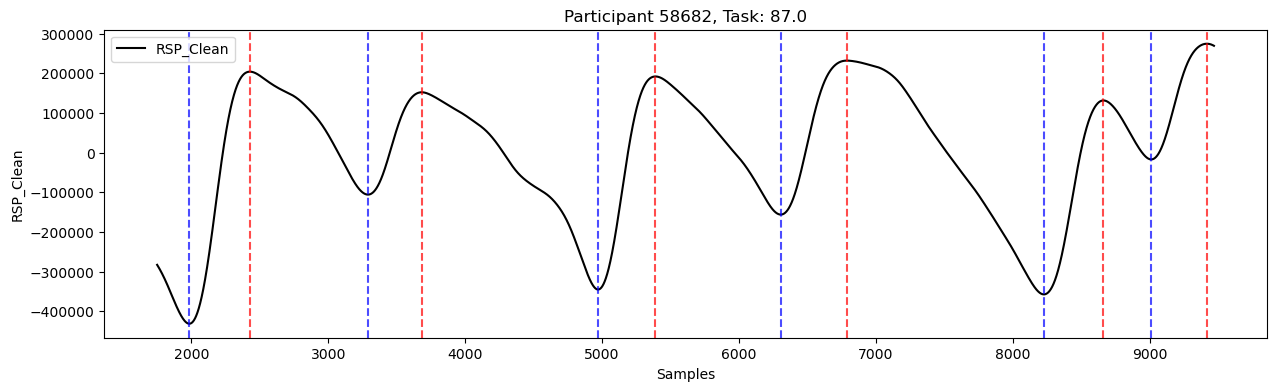

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


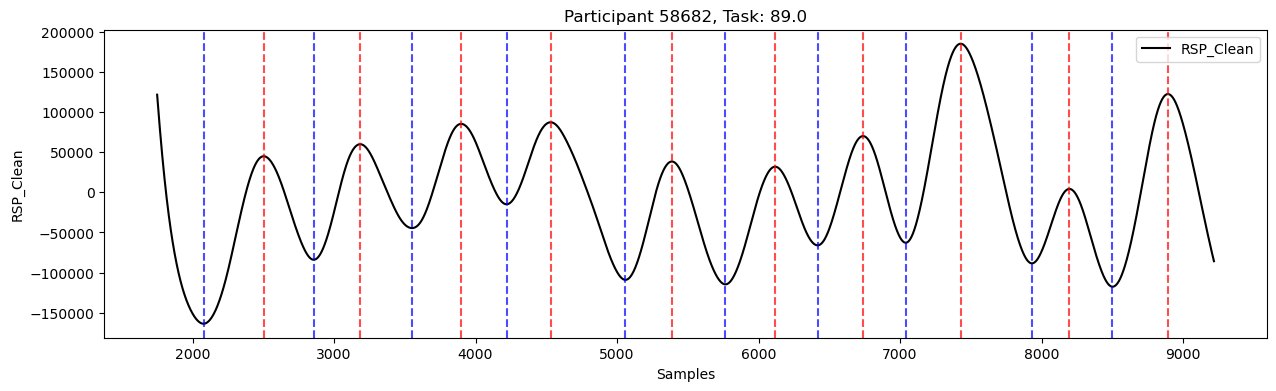

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


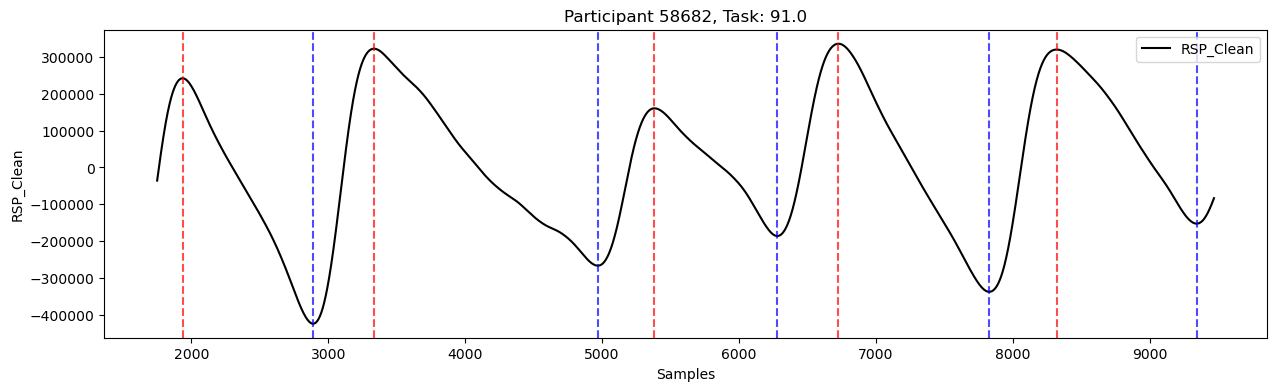

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


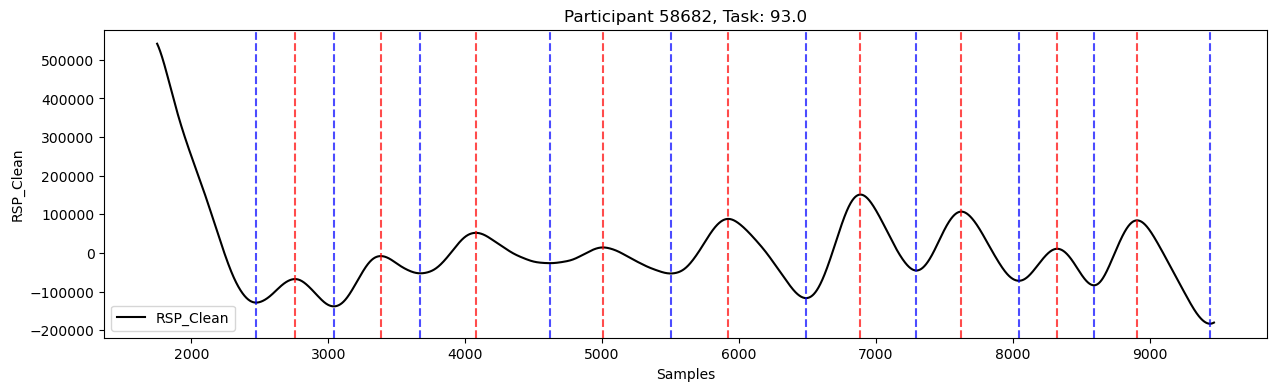

In [4]:
#define the tasks, enter the participant ID to process and to visualize

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

participant_ids = [58682]  # enter your participant ID here

all_processed_data_impedance = {}
for participant_id in participant_ids:
    processed_dataframes_impedance = process_and_visualize_impedance(df_impedance, participant_id, tasks)
    all_processed_data_impedance[participant_id] = processed_dataframes_impedance


In [5]:
#to print peaks and troughs, enter the participant ID 
participant_id = 58682 
processed_dataframes = all_processed_data_impedance[participant_id]

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # Identify the actual task portion in the dataframe
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # Extract the indices of peaks and troughs within the task-specific part
        peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
        troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

        # Print identified peaks and troughs
        print(f"Peaks for task {task}: {peaks.tolist()}")
        print(f"Number of Peaks: {len(peaks)}")
        print(f"Troughs for task {task}: {troughs.tolist()}")
        print(f"Number of Troughs: {len(troughs)}")
        print("\n")


Task: 12.0a
Peaks for task 12.0a: [2450, 3809, 4920, 6121, 7398, 8607]
Number of Peaks: 6
Troughs for task 12.0a: [3312, 4430, 5569, 6860, 8026, 9198]
Number of Troughs: 6


Task: 12.0b
Peaks for task 12.0b: [2145, 3417, 4906, 5953, 6788, 7682, 8641]
Number of Peaks: 7
Troughs for task 12.0b: [2748, 4458, 5558, 6406, 7238, 8239, 9114]
Number of Troughs: 7


Task: 12.0c
Peaks for task 12.0c: [2068, 3061, 3981, 5006, 5944, 7090, 8058, 8887]
Number of Peaks: 8
Troughs for task 12.0c: [2655, 3535, 4594, 5539, 6480, 7683, 8465]
Number of Troughs: 7


Task: 12.0d
Peaks for task 12.0d: [2677, 3566, 4375, 5222, 6164, 6951, 7714, 8453, 9187]
Number of Peaks: 9
Troughs for task 12.0d: [2235, 3188, 4017, 4814, 5701, 6610, 7333, 8092, 8828]
Number of Troughs: 9


Task: 12.0e
Peaks for task 12.0e: [2432, 3123, 3828, 4588, 5369, 6407, 7397, 8214, 9010]
Number of Peaks: 9
Troughs for task 12.0e: [2089, 2792, 3474, 4230, 4993, 5874, 7008, 7833, 8645]
Number of Troughs: 9


Task: 12.0f
Peaks for task 1

C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\888898372.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\888898372.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


In [6]:
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmery)
import numpy as np #now with the corrected exp diff and duty cycle calculations
import pandas as pd

participant_id = 58682  # Enter the participant ID here
processed_dataframes = all_processed_data_impedance[participant_id]
sampling_rate = 250  # Adjusted to 250 Hz for 5fs device, change if your sampling rate is different
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # identifying the actual task portion in the dataframe
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # extracting the indices of peaks and troughs within the task-specific part
        peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
        troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

        # combining peaks and troughs into one list and sorting them
        combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
        combined_data.sort(key=lambda x: x[1])

        # initialize lists to store the respiratory features
        inspiratory_durations = []
        expiratory_durations = []
        inspiratory_amplitudes = []
        expiratory_amplitudes = []
        inspiratory_flows = []
        expiratory_flows = []
        ie_ratios = []
        duty_cycles = []  # Reinitialize to collect correctly
        exp_diffs = []

        # iterate through combined data
        for i in range(1, len(combined_data)):
            current_type, current_index = combined_data[i]
            prev_type, prev_index = combined_data[i-1]

            # duration and amplitude calculation
            duration = (current_index - prev_index) / sampling_rate
            amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

            if current_type == 'Peak' and prev_type == 'Trough':
                inspiratory_durations.append(duration)
                inspiratory_amplitudes.append(amplitude)
                if duration > 0:
                    inspiratory_flows.append(amplitude / duration)
            elif current_type == 'Trough' and prev_type == 'Peak':
                expiratory_durations.append(duration)
                expiratory_amplitudes.append(amplitude)
                if duration > 0:
                    expiratory_flows.append(amplitude / duration)
                if inspiratory_durations:
                    # IE ratio
                    ie_ratio = inspiratory_durations[-1] / duration
                    ie_ratios.append(ie_ratio)
                    # Duty Cycle for the same breathing cycle
                    total_cycle_duration = inspiratory_durations[-1] + duration
                    duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                    duty_cycles.append(duty_cycle)

        # calculate expiratory differences
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

        # Mean and SD calculations
        insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
        exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
        insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
        exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
        insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
        exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
        ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
        duty_cycle_mean = np.mean(duty_cycles) if duty_cycles else 0
        exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

        # storing the results
        task_results[task] = {
            'insp_dur_mean': insp_dur_mean,
            'insp_dur_sd': insp_dur_sd,
            'exp_dur_mean': exp_dur_mean,
            'exp_dur_sd': exp_dur_sd,
            'insp_amp_mean': insp_amp_mean,
            'insp_amp_sd': insp_amp_sd,
            'exp_amp_mean': exp_amp_mean,
            'exp_amp_sd': exp_amp_sd,
            'insp_flow_mean': insp_flow_mean,
            'insp_flow_sd': insp_flow_sd,
            'exp_flow_mean': exp_flow_mean,
            'exp_flow_sd': exp_flow_sd,
            'ie_ratio_mean': ie_ratio_mean,
            'ie_ratio_sd': ie_ratio_sd,
            'duty_cycle_mean': duty_cycle_mean,
            'exp_diff_mean': exp_diff_mean
        }

        # storing the breath-by-breath results separately
        bbb_results[task] = {
            'inspiratory_durations': inspiratory_durations,
            'expiratory_durations': expiratory_durations,
            'inspiratory_amplitudes': inspiratory_amplitudes,
            'expiratory_amplitudes': expiratory_amplitudes,
            'inspiratory_flows': inspiratory_flows,
            'expiratory_flows': expiratory_flows,
            'ie_ratios': ie_ratios,
            'duty_cycles': duty_cycles,
            'exp_diffs': exp_diffs
        }

# convert the dictionary to a DataFrame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a DataFrame for bbb_results (these are breath by breath values such as inspiration time and expiration time)
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

# Display the dataframe with the features (main goal)
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c


C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\2587388614.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_18676\2587388614.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.126400     0.136531      2.726667    0.371144   
1       12.0b       1.826667     0.392215      2.416571    0.769654   
2       12.0c       1.757714     0.289424      2.138857    0.271552   
3       12.0d       1.551556     0.156455      1.730500    0.188244   
4       12.0e       1.524444     0.225688      1.745500    0.307011   
..        ...            ...          ...           ...         ...   
61       85.0       1.298500     0.309354      2.106667    0.783744   
62       87.0       1.718667     0.117113      3.882400    1.518280   
63       89.0       1.382000     0.176030      1.493333    0.325617   
64       91.0       1.798000     0.111229      4.486400    1.060673   
65       93.0       1.404444     0.201606      1.691556    0.447891   

    insp_amp_mean    insp_amp_sd   exp_amp_mean     exp_amp_sd  \
0   650146.276812   70600.548038  742017.902103  342259.208114   
1   570761.003003  269837.720625  574219.564054  221412.096644   
2   501915.894250  139988.467716  506211.379703  148965.337367   
3   444707.838619   91446.028908  446158.581037   81089.982099   
4   404326.758616  142246.641164  415860.750530  138656.837271   
..            ...            ...            ...            ...   
61  123884.795208   84932.022728  174476.374288   93700.600582   
62  433350.132099  133917.824640  378808.791483  153006.904490   
63  159509.002386   51417.646059  145445.564696   53793.223385   
64  587405.357562  122500.216795  548731.594690  124414.208642   
65  127641.862089   63839.358171  133716.250159   74457.211740   

    insp_flow_mean  insp_flow_sd  exp_flow_mean   exp_flow_sd  ie_ratio_mean  \
0    305181.160875  20273.901841  263439.262541  81180.834779       0.828411   
1    303273.651465  85972.135792  243329.746995  67472.328775       0.782941   
2    281380.336115  34373.093450  233981.132642  49233.874606       0.843789   
3    285148.475819  39369.346919  257957.672629  34960.401471       0.908970   
4    260537.405212  50193.322649  235801.054062  46309.116679       0.883493   
..             ...           ...            ...           ...            ...   
61    86186.428772  47684.552797   87718.073161  43584.830582       0.699451   
62   250929.294167  73483.464018   98114.550424   5817.097997       0.571599   
63   113130.960671  24462.706059   95691.219615  18204.828471       0.944378   
64   325351.182286  60286.010803  125787.787280  32714.148562       0.405202   
65    90619.123054  40976.032913   77928.453636  34274.885715       0.871328   

    ie_ratio_sd  duty_cycle_mean  exp_diff_mean  
0      0.086642         0.451892       0.405600  
1      0.087390         0.437737       0.813333  
2      0.105405         0.455916       0.385333  
3      0.077930         0.475299       0.123429  
4      0.058889         0.468529       0.245143  
..          ...              ...            ...  
61     0.183142         0.404143       1.145000  
62     0.346043         0.338587       2.409000  
63     0.189020         0.480577       0.448500  
64     0.081491         0.285837       1.700000  
65     0.175545         0.460934       0.481500  

[66 rows x 17 columns]

In [7]:
#below, we extract the features we can from neurokit (as we need three of them)
import pandas as pd
import neurokit2 as nk

processed_dataframes = all_processed_data_impedance[participant_id]  # Ensure this is the correct dictionary for 5fs

# list to store interval-related features for each task
interval_features_list = []

for task, df in processed_dataframes.items():
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # Extract the task-specific part of the dataframe
        task_specific_df = df.loc[task_start:task_end]

        # Extract interval-related features using nk.rsp_intervalrelated()
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=250)

        # Add a column for the task label
        features_df['Task_Label'] = task

        # Append the features DataFrame to the list
        interval_features_list.append(features_df)

# Concatenate all feature DataFrames
interval_features_df = pd.concat(interval_features_list, ignore_index=True)

# Display the DataFrame
interval_features_df


C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.188415   396.010101  4708.800000   268.825594   453.001840   
1       14.010062  1239.738037  4244.000000  1337.134847  1167.650633   
2       15.548124   964.884242  3873.333333   585.432034  1075.206399   
3       17.440232   374.638874  3296.500000   340.617506   381.848137   
4       18.520138   640.622911  3278.000000   570.677793   688.673535   
..            ...          ...          ...          ...          ...   
61      17.704441  1863.564020  3298.500000  1013.763427  2009.203396   
62      10.449037  2753.771959  5620.000000  1723.278271  3122.353599   
63      20.896271   686.708089  2854.666667   418.626325   725.489391   
64       9.769263  1857.714725  6453.000000  1310.854683  2080.480714   
65      18.767813   753.203824  3096.000000   644.847269   791.177062   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB  RRV_MadBB  RRV_MCVBB  ...  \
0   0.057090  0.084100        4664.0   160.1208   0.034331  ...   
1   0.315065  0.292115        3752.0   581.1792   0.154899  ...   
2   0.151144  0.249110        3772.0   530.7708   0.140713  ...   
3   0.103327  0.113647        3252.0   447.7452   0.137683  ...   
4   0.174093  0.195431        3150.0   361.7544   0.114843  ...   
..       ...       ...           ...        ...        ...  ...   
61  0.307341  0.564973        3084.0   812.4648   0.263445  ...   
62  0.306633  0.489995        5340.0  2045.9880   0.383144  ...   
63  0.146646  0.240556        2776.0   421.0584   0.151678  ...   
64  0.203139  0.287884        6126.0   702.7524   0.114716  ...   
65  0.208284  0.243283        3224.0   824.3256   0.255684  ...   

           RAV_SD      RAV_RMSSD  RAV_CVSD        RSP_RVT  \
0   367927.659662  429076.333059  0.537986  148064.437253   
1   269837.721427  447448.479316  0.783961  125659.444434   
2   145753.152559  256695.357213  0.497216  128704.071827   
3    96993.160730  106649.029415  0.239818  130260.102483   
4   150875.346852  221319.876025  0.547379  125208.118551   
..            ...            ...       ...            ...   
61  165904.590086  216797.844527  1.264937   42769.842284   
62  146699.626815  241554.616288  0.557412   59220.831460   
63   54198.957824   85359.511072  0.535139   55857.028018   
64  122625.775052  193767.934331  0.328483   78892.317291   
65   67711.864604   87442.278589  0.685060   40452.760008   

    RSP_Symmetry_PeakTrough  RSP_Symmetry_RiseDecay  \
0                  0.594621                0.452545   
1                  0.539390                0.431522   
2                  0.541158                0.443832   
3                  0.551320                0.468435   
4                  0.527998                0.468744   
..                      ...                     ...   
61                 0.547458                0.399114   
62                 0.456304                0.338115   
63                 0.508182                0.474470   
64                 0.483620                0.283083   
65                 0.537316                0.454257   

    RSP_Phase_Duration_Inspiration  RSP_Phase_Duration_Expiration  \
0                         2.122400                       2.722667   
1                         1.822667                       2.412571   
2                         1.753714                       2.134857   
3                         1.547556                       1.726500   
4                         1.520444                       1.741500   
..                             ...                            ...   
61                        1.294500                       2.102667   
62                        1.714667                       3.878400   
63                        1.378000                       1.489333   
64                        1.794000                       4.482400   
65                        1.400444                       1.687556   

    RSP_Phase_Duration_Ratio  Task_Label  
0                   0.779530       12.0a  
1            

In [8]:
#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [9]:
#checking if we have missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)

Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [10]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']
#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 58682

In [11]:
# Adding 'ImP_' to the beginning of all column names
respiratory_analysis_df_2.columns = 'ImP_' + respiratory_analysis_df_2.columns

# Display the modified DataFrame
respiratory_analysis_df_2


ImP_Task_Label  ImP_insp_dur_mean  ImP_insp_dur_sd  ImP_exp_dur_mean  \
0           12.0a           2.126400         0.136531          2.726667   
1           12.0b           1.826667         0.392215          2.416571   
2           12.0c           1.757714         0.289424          2.138857   
3           12.0d           1.551556         0.156455          1.730500   
4           12.0e           1.524444         0.225688          1.745500   
..            ...                ...              ...               ...   
61           85.0           1.298500         0.309354          2.106667   
62           87.0           1.718667         0.117113          3.882400   
63           89.0           1.382000         0.176030          1.493333   
64           91.0           1.798000         0.111229          4.486400   
65           93.0           1.404444         0.201606          1.691556   

    ImP_exp_dur_sd  ImP_insp_amp_mean  ImP_insp_amp_sd  ImP_exp_amp_mean  \
0         0.371144      650146.276812     70600.548038     742017.902103   
1         0.769654      570761.003003    269837.720625     574219.564054   
2         0.271552      501915.894250    139988.467716     506211.379703   
3         0.188244      444707.838619     91446.028908     446158.581037   
4         0.307011      404326.758616    142246.641164     415860.750530   
..             ...                ...              ...               ...   
61        0.783744      123884.795208     84932.022728     174476.374288   
62        1.518280      433350.132099    133917.824640     378808.791483   
63        0.325617      159509.002386     51417.646059     145445.564696   
64        1.060673      587405.357562    122500.216795     548731.594690   
65        0.447891      127641.862089     63839.358171     133716.250159   

    ImP_exp_amp_sd  ImP_insp_flow_mean  ...  ImP_exp_flow_sd  \
0    342259.208114       305181.160875  ...     81180.834779   
1    221412.096644       303273.651465  ...     67472.328775   
2    148965.337367       281380.336115  ...     49233.874606   
3     81089.982099       285148.475819  ...     34960.401471   
4    138656.837271       260537.405212  ...     46309.116679   
..             ...                 ...  ...              ...   
61    93700.600582        86186.428772  ...     43584.830582   
62   153006.904490       250929.294167  ...      5817.097997   
63    53793.223385       113130.960671  ...     18204.828471   
64   124414.208642       325351.182286  ...     32714.148562   
65    74457.211740        90619.123054  ...     34274.885715   

    ImP_ie_ratio_mean  ImP_ie_ratio_sd  ImP_duty_cycle_mean  \
0            0.828411         0.086642             0.451892   
1            0.782941         0.087390             0.437737   
2            0.843789         0.105405             0.455916   
3            0.908970         0.077930             0.475299   
4            0.883493         0.058889             0.468529   
..                ...              ...                  ...   
61           0.699451         0.183142             0.404143   
62           0.571599         0.346043             0.338587   
63           0.944378         0.189020             0.480577   
64           0.405202         0.081491             0.285837   
65           0.871328         0.175545             0.460934   

    ImP_exp_diff_mean  ImP_RSP_Symmetry_PeakTrough  ImP_RRV_RMSSD  \
0            0.405600                     0.594621     396.010101   
1            0.813333                     0.539390    1239.738037   
2            0.385333                     0.541158     964.884242   
3            0.123429                     0.551320     374.638874   
4            0.245143                     0.527998     640.622911   
..                ...                          ...            ...   
61           1.145000                     0.547458    1863.564020   
62           2.409000                     0.456304    2753.771959   
63           0.448500                     

In [ ]:
import pandas as pd

# Create an ExcelWriter object
writer = pd.ExcelWriter('features_impedance_58682.xlsx', engine='xlsxwriter')

# Convert the dataframe to an Excel sheet within the ExcelWriter object
respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

# Save the ExcelWriter object to disk
writer.save()